# 1. 分析数据分布

In [1]:
import json
import numpy as np
import torch
# Load model directly
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

# tokenizer_path = "/home/wangyuxin//.cache/huggingface/hub/models--mistralai--Mixtral-8x7B-Instruct-v0.1/snapshots"
# data_path = '/home/nus-hx/code/Sequence-Scheduling/data/alpaca-train-10k.json'
tokenizer_path = "/home/nus-hx/.cache/huggingface/hub/models--mistralai--Mixtral-8x7B-Instruct-v0.1/snapshots/125c431e2ff41a156b9f9076f744d2f35dd6e67a"
data_path = '/home/nus-hx/code/Sequence-Scheduling/data/alpaca-train-10k.json'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
print(tokenizer)
def load_json(file):
    with open(file, 'r') as f:
        data = json.load(f)
    return data

alpaca_data = load_json(data_path)

LlamaTokenizerFast(name_or_path='/home/nus-hx/.cache/huggingface/hub/models--mistralai--Mixtral-8x7B-Instruct-v0.1/snapshots/125c431e2ff41a156b9f9076f744d2f35dd6e67a', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


## 1.1 alpaca数据分析

text length 21 34.1237 287
#tokens 37 58.2928 384


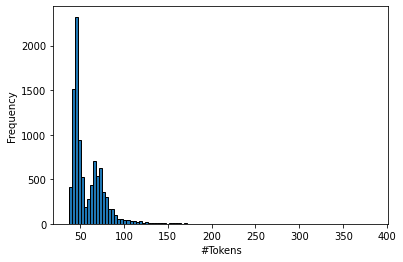

In [2]:
num_samples = len(alpaca_data)
data = {}
lengths = []
tokens = []
for i in range(num_samples):
    prompt = alpaca_data[i]['conversations'][0]['value']
    ids = tokenizer.encode(prompt)
    data[i] = {
        'prompt': prompt,
        'length': len(prompt.split(' ')),    
        'num_tokens': len(ids)    
    }
    lengths.append(len(prompt.split(' ')))
    tokens.append(len(ids))
print('text length', np.min(lengths), np.mean(lengths), np.max(lengths))
print('#tokens', np.min(tokens), np.mean(tokens), np.max(tokens))


# # 示例数据：替换成您的实际数据
# lengths = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

# 对长度进行排序
sorted_lengths = sorted(tokens)

# 绘制直方图
plt.hist(sorted_lengths, bins=100, edgecolor='black')

# 添加标题和标签
# plt.title('Token Length Distribution')
plt.xlabel('#Tokens')
plt.ylabel('Frequency')

# 显示图形
plt.show()


## 1.2 Yizhong 数据集


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


text length 10 127.83606 921
#tokens 25 197.00168 1456


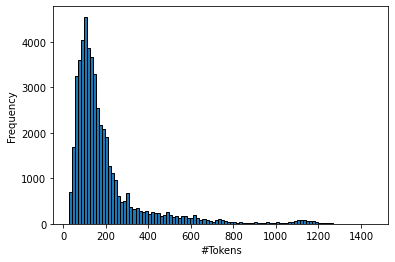

In [3]:
from datasets import load_dataset
dataset = load_dataset("yizhongw/self_instruct", "super_natural_instructions")
data_prompts = dataset['train']['prompt']
num_samples = len(data_prompts)
data = {}
lengths = []
tokens = []
for i in range(num_samples):
    prompt = data_prompts[i]
    ids = tokenizer.encode(prompt)
    data[i] = {
        'prompt': prompt,
        'length': len(prompt.split(' ')),    
        'num_tokens': len(ids)    
    }
    lengths.append(len(prompt.split(' ')))
    tokens.append(len(ids))
print('text length', np.min(lengths), np.mean(lengths), np.max(lengths))
print('#tokens', np.min(tokens), np.mean(tokens), np.max(tokens))

# # 示例数据：替换成您的实际数据
# lengths = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

# 对长度进行排序
sorted_lengths = sorted(tokens)

# 绘制直方图
plt.hist(sorted_lengths, bins=100, edgecolor='black')

# 添加标题和标签
# plt.title('Token Length Distribution')
plt.xlabel('#Tokens')
plt.ylabel('Frequency')

# 显示图形
plt.show()


## 1.3 unknown

In [ ]:
import json
import numpy as np
import torch

def load_json(file):
    with open(file, 'r') as f:
        data = json.load(f)
    return data

# data = load_json('/home/nus-hx/code/ColossalAI/examples/language/openmoe/expert_input_statistics_yizhongw.json')
# data = load_json('/home/nus-hx/code/ColossalAI/examples/language/openmoe/expert_input_statistics.json')



In [ ]:
data = load_json("/home/nus-hx/code/Sequence-Scheduling/data/alpaca-train-10k.json")
data[1]['conversations'][0]['value']


In [ ]:
def preprocess(data):
    all_num_tokens_per_expert = []
    # all_id_value_per_expert = []
    for layer_id, layer_expert_info in data.items():
        all_num_tokens_per_expert.append([])
        # all_id_value_per_expert.append([])
        for expert_idx, expert_info in layer_expert_info.items():
            all_num_tokens_per_expert[-1].append(expert_info[1:])
            # all_id_value_per_expert[-1].append(expert_info['id_value_per_expert'])
    return torch.tensor(all_num_tokens_per_expert)
    # return torch.tensor(all_num_tokens_per_expert), torch.tensor(all_id_value_per_expert)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_num_tokens(num_tokens, stpes=5):
    num_layers, num_experts, num_steps = num_tokens.shape
    num_steps = min(stpes, num_steps)
    # 创建一个子图，每个步骤一个子图
    fig, axs = plt.subplots(num_steps, 1, figsize=(num_experts, num_layers * num_steps))

    for step in range(num_steps):
        matrix = num_tokens[:, :, step]

        # 绘制热图
        im = axs[step].imshow(matrix, cmap='viridis')

        # 显示颜色条
        cbar = axs[step].figure.colorbar(im, ax=axs[step])

        # 设置坐标轴标签
        axs[step].set_xticks(np.arange(num_experts))
        axs[step].set_yticks(np.arange(num_layers))
        axs[step].set_xticklabels([f'Expert {i}' for i in range(num_experts)])
        axs[step].set_yticklabels([f'Layer {i}' for i in range(num_layers)])

        # 在矩阵元素上显示数值
        for i in range(num_layers):
            for j in range(num_experts):
                axs[step].text(j, i, f'{matrix[i, j]:.2f}', ha='center', va='center', color='w')

        axs[step].set_title(f'Step {step + 1}')

    # 调整子图布局
    plt.tight_layout()
    plt.show()


In [ ]:
import torch

def kl_divergence(matrix1, matrix2, eps=1e-10):
    """
    计算两个矩阵每一行数据的KL散度（PyTorch版本）
    """
    # 将每一行的数据归一化为概率分布epsilon = 1e-10  # 或者选择适当的小值
    distributions1 = (matrix1 + eps) / torch.sum(matrix1 + eps, dim=1, keepdim=True)
    distributions2 = (matrix2 + eps) / torch.sum(matrix2 + eps, dim=1, keepdim=True)


    # 避免对数计算中出现无穷大值
    distributions1 = torch.where(torch.isnan(distributions1), torch.tensor(0.0), distributions1)
    distributions2 = torch.where(torch.isnan(distributions2), torch.tensor(0.0), distributions2)

    # 计算KL散度
    kl = torch.sum(distributions1 * torch.log(distributions1 / distributions2), dim=1)

    return kl


def jensen_shannon_divergence(matrix1, matrix2, epsilon=1e-10):
    # 将每一行的数据归一化为概率分布
    distributions1 = (matrix1 + epsilon) / (torch.sum(matrix1, dim=1, keepdim=True) + epsilon)
    distributions2 = (matrix2 + epsilon) / (torch.sum(matrix2, dim=1, keepdim=True) + epsilon)

    # 计算平均分布
    average_distribution = 0.5 * (distributions1 + distributions2)

    # 计算KL散度
    kl_divergence1 = torch.sum(distributions1 * torch.log(distributions1 / (average_distribution + epsilon)), dim=1)
    kl_divergence2 = torch.sum(distributions2 * torch.log(distributions2 / (average_distribution + epsilon)), dim=1)

    # 计算Jensen-Shannon散度
    js_divergence = 0.5 * (kl_divergence1 + kl_divergence2)
    similarity = 1 - 2 * js_divergence
    return js_divergence, similarity


In [ ]:
# use cache
data = load_json('/home/nus-hx/code/vllm/examples/4_expert_input_statistics.json')
num_tokens = preprocess(data) # (num_layers, num_experts, num_steps)
prefilling = num_tokens[..., 0]
decoding = num_tokens[..., 1:].sum(-1)
js, sim = jensen_shannon_divergence(prefilling, decoding)
# print(f"prefilling #tokens: {prefilling}")
# print(f"decoding #tokens: {decoding}")
print(f"js: {js.numpy()} 相似度: {sim}\n")

import numpy as np
from scipy.stats import spearmanr, pearsonr

# 创建两个示例矩阵
matrix1 = prefilling
matrix2 = decoding

# 计算Pearson相关系数
pearson_corr, _ = pearsonr(matrix1.flatten(), matrix2.flatten())
print(f"Pearson Correlation: {pearson_corr}")

# 计算Spearman等级相关系数
spearman_corr, _ = spearmanr(matrix1.flatten(), matrix2.flatten())
print(f"Spearman Rank Correlation: {spearman_corr}")

print(sim.mean())

In [ ]:
plot_num_tokens(num_tokens, 10)


In [ ]:
for i in range(1, 10):
    data = load_json(f'/home/nus-hx/code/ColossalAI/examples/language/openmoe/{i}_expert_input_statistics.json')
    num_tokens, id_values = preprocess(data) # (num_layers, num_experts, num_steps)
    prefilling = num_tokens[..., 0]
    decoding = num_tokens[..., 1:].sum(-1)
    js, sim = jensen_shannon_divergence(prefilling, decoding)
    print(f"{i}-th sample:")
    print(f"prefilling #tokens: {prefilling}")
    print(f"decoding #tokens: {decoding}")
    print(f"js: {js.numpy()} 相似度: {sim}\n")

In [ ]:
plot_num_tokens(num_tokens, 10)

## use cache
data = load_json('/home/nus-hx/code/ColossalAI/examples/language/openmoe/expert_input_statistics_no_cache.json')
num_tokens, id_values = preprocess(data)
for step in range(10):
    print(num_tokens[0,:,step].numpy(), num_tokens[0,:,step].numpy().sum())

In [ ]:
def preprocess(data):
    id_means = []
    id_stds = []
    for layer_id, layer_expert_info in data.items():
        id_means.append([])
        id_stds.append([])
        for expert_idx, expert_info in layer_expert_info.items():
            id_means[-1].append(np.mean(expert_info))
            id_stds[-1].append(np.std(expert_info))
    id_means, id_stds = np.array(id_means), np.array(id_stds)
#     print('means:\n', id_means)
#     print('stds:\n', id_stds)
    return id_means, id_stds

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_variance(matrix_mean, matrix_var, is_sort=True):
    if is_sort:
        # 对均值矩阵按行排序
        sorted_indices = np.argsort(matrix_mean, axis=1)
        sorted_matrix_mean = np.take_along_axis(matrix_mean, sorted_indices, axis=1)
        sorted_matrix_var = np.take_along_axis(matrix_var, sorted_indices, axis=1)
    else:
        sorted_matrix_mean = matrix_mean
        sorted_matrix_var = matrix_var

    num_layers, num_experts = sorted_matrix_mean.shape

    plt.figure(figsize=(10, 6 * num_layers))  # 设置图表尺寸，每一层一个子图

    for layer in range(num_layers):
        plt.subplot(num_layers, 1, layer + 1)  # 创建子图
        mean_values = sorted_matrix_mean[layer]  # 获取当前层的均值
        var_values = sorted_matrix_var[layer]  # 获取当前层的方差

        # 绘制图表，均值用条形图表示，方差用error bar表示
        plt.bar(np.arange(num_experts), mean_values, yerr=var_values, capsize=5)
        plt.xlabel('Expert Index')
        plt.ylabel('Mean Value')
        plt.title(f'Layer {layer + 1}')

    plt.tight_layout()  # 调整布局
    plt.show()

# # 测试示例
# num_layer = 4
# num_expert = 6
# matrix_mean = np.random.randint(1, 50, size=(num_layer, num_expert))  # 生成随机均值矩阵
# matrix_var = np.random.randint(1, 20, size=(num_layer, num_expert))  # 生成随机方差矩阵
# print("原始均值矩阵：")
# print(matrix_mean)
# print("原始方差矩阵：")
# print(matrix_var)
# plot_mean_variance(matrix_mean, matrix_var, is_sort=False)


In [ ]:
data_yizhongw = preprocess(load_json('/home/nus-hx/code/ColossalAI/examples/language/openmoe/expert_input_statistics_yizhongw.json'))
# data_wikitext = preprocess(load_json('/home/nus-hx/code/ColossalAI/examples/language/openmoe/expert_input_statistics_wikitext.json'))
data_wikitext = preprocess(load_json('/home/nus-hx/code/ColossalAI/examples/language/openmoe/expert_input_statistics.json'))

In [ ]:
plot_mean_variance(*data_yizhongw, False)

In [ ]:
plot_mean_variance(*data_wikitext, True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_expert_values(matrix, to_sort=False):
    sorted_matrix = matrix
    if to_sort:
        sorted_matrix = np.sort(matrix, axis=1)  # 对矩阵按行排序
        print(f"排序后矩阵：\n", sorted_matrix)

    num_layers, num_experts = sorted_matrix.shape

    plt.figure(figsize=(10, 6 * num_layers))  # 设置图表尺寸，每一层一个子图

    for layer in range(num_layers):
        plt.subplot(num_layers, 1, layer + 1)  # 创建子图
        values = sorted_matrix[layer]  # 获取当前层的数值

        # 绘制图表
        plt.bar(np.arange(num_experts), values)
        plt.xlabel('Expert Index')
        plt.ylabel('Value')
        plt.title(f'Layer {layer + 1}')

    plt.tight_layout()  # 调整布局
    plt.show()

# 测试示例
num_layer = 4
num_expert = 6
matrix = np.random.randint(1, 50, size=(num_layer, num_expert))  # 生成随机矩阵


# results on yizhongw
matrix = [   
    [0,0,5.544073,10.722609,6.840683,3.627592,4.612808,4.135404,4.916871,6.619530,6.562585,5.101259,5.618176,6.037780,6.207156,5.236032],
    [0,0,4.355231,5.640529,7.701429,8.725691,11.453165,9.376528,6.904047,5.065467,6.500171,8.404157,5.460723,4.534373,6.314137,8.272322],
    [0,0,5.698514,10.105216,8.807961,6.142078,6.140738,7.836411,10.673695,5.086765,7.178852,5.035629,3.078635,6.750798,9.594976,8.384435]
]
matrix = np.array(matrix)
matrix = np.nan_to_num(matrix)
print("原始矩阵：")
print(matrix)
plot_expert_values(matrix, True)


In [ ]:
matrix = [
    [0,0,5.544073,10.722609,6.840683,3.627592,4.612808,4.135404,4.916871,6.619530,6.562585,5.101259,5.618176,6.037780,6.207156,5.236032],
    [0,0,4.355231,5.640529,7.701429,8.725691,11.453165,9.376528,6.904047,5.065467,6.500171,8.404157,5.460723,4.534373,6.314137,8.272322],
    [0,0,5.698514,10.105216,8.807961,6.142078,6.140738,7.836411,10.673695,5.086765,7.178852,5.035629,3.078635,6.750798,9.594976,8.384435],
]

matrix = np.array(matrix)
matrix = np.nan_to_num(matrix)
print("原始矩阵：")
print(matrix)
plot_expert_values(matrix, True)

In [ ]:
# results on Wikitext-2-v1

matrix = [
    [0.000000,0.000000,7.963334,7.248610,5.389153,5.796610,4.887456,5.961907,5.427928,5.641143,3.553481,4.450169,6.972357,4.594432,8.926065,7.169308],
[0.000000,10.373790,6.114333,11.607411,11.788904,12.568120,9.828843,9.701502,9.960600,5.349957,8.947469,11.169651,6.741775,8.415722,8.856209,8.982792],
[0.000000,0.000000,5.875930,7.778467,9.251879,11.587394,13.382789,10.927470,10.783409,9.167251,11.630848,9.831821,13.274390,6.963855,12.515475,8.359204]
]

matrix = np.array(matrix)
matrix = np.nan_to_num(matrix)
print("原始矩阵：")
print(matrix)
plot_expert_values(matrix)

In [ ]:

plot_expert_values(matrix, True)

# 1. 导入依赖库和数据

In [9]:
import torch
import numpy as np
num_samples = 10000
pt = torch.load(f'../alpaca_{num_samples}_samples.pt')
pt = torch.load(f'../yizhong_{num_samples}.pt')
type(pt), len(pt)

(list, 10000)

# 2. 定义数据解析函数

In [10]:

def get_prompt_expert_trace(seq_group):
    t2e = seq_group.token2experts
    seq = seq_group.get_seqs()[0]
    num_layers = len(t2e[0]) - 1
    num_experts = 8
    expert_trace = torch.zeros((num_layers, num_experts)).to(torch.cuda.current_device())
    prompt_len = seq.get_prompt_len()
    for i_token in range(prompt_len):
        for layer_id in t2e[i_token]:
            if isinstance(layer_id, int):
                experts = t2e[i_token][layer_id][0]
                for expert_id in experts:
                    expert_trace[layer_id][expert_id] += 1
    return expert_trace

def get_output_expert_trace(seq_group):
    t2e = seq_group.token2experts
    seq = seq_group.get_seqs()[0]
    num_layers = len(t2e[0]) - 1
    num_experts = 8
    expert_trace = torch.zeros((num_layers, num_experts)).to(torch.cuda.current_device())
    prompt_len = seq.get_prompt_len()
    output_len = len(seq.get_output_token_ids())
    all_length = len(seq.get_token_ids())
    # print(f"all:{all_length}=prompt({prompt_len}) + output({output_len})")
    assert prompt_len+output_len == all_length
    for i_token in range(prompt_len, all_length-1):
        for layer_id in t2e[i_token]:
            if isinstance(layer_id, int):
                experts = t2e[i_token][layer_id][0]
                for expert_id in experts:
                    expert_trace[layer_id][expert_id] += 1
    return expert_trace

def parse_seq_group(seq_group):
    prompt_expert_trace = get_prompt_expert_trace(seq_group)
    output_expert_trace = get_output_expert_trace(seq_group)
    seq = seq_group.get_seqs()[0]
    token_ids = seq.get_token_ids()
    prompt_len = seq.get_prompt_len()
    prompt_ids = token_ids[:prompt_len]
    output_ids = seq.get_output_token_ids()
    output_len = len(output_ids)
    return {
        'prompt_ids': prompt_ids,
        'output_ids': output_ids,
        'token_ids': token_ids,
        'prompt_len': prompt_len,
        'output_len': output_len,
        'prompt_expert_trace': prompt_expert_trace,
        'output_expert_trace': output_expert_trace
    }

def get_token_expert_trace(per_token2experts):
    trace = []
    for i in range(len(per_token2experts)-1):
        trace.append(per_token2experts[i][0])
    return torch.from_numpy(np.array(trace))


In [ ]:

seq_group = pt[0].outputs[0].seq_group
token2experts = seq_group.token2experts
seq = seq_group.get_seqs()[0]

data = parse_seq_group(seq_group)
data.keys(), data['prompt_expert_trace'][:5], get_token_expert_trace(seq_group.token2experts[0])[:5]

token_ids = seq.get_token_ids()
output_ids = seq.get_output_token_ids()
prompt_len = seq.get_prompt_len()
print(f'length: {len(token_ids)}={prompt_len}+{len(output_ids)}')
print('All:', token_ids)
print('prompt:', token_ids[:prompt_len])
print('output:', output_ids)
unique_ids = []
repeat_ids = {}
for i, idx in enumerate(token_ids):
    if idx not in unique_ids:
        unique_ids.append(idx)
    else:
        if idx not in repeat_ids:
            repeat_ids[idx] = [i]
        else:
            repeat_ids[idx].append(i)
print('unique:', f"{len(unique_ids)}/{seq.get_len()}")
print('repeat:', repeat_ids)

# 3. 解析数据

## 3.1 分析单个 token 的 expert_trace

查看分析单个 token 的 expert_trace是否与上下文无关

In [11]:
# 计算指定 token 的 expert_trace (L,2)在不同上下文的相似性
def get_consistency_score_token_expert_trace(t2e_pool, token_idx: int):
    data = torch.stack( t2e_pool[token_idx]['trace'] ).sort(-1)
    scores = torch.zeros(len(data), len(data))
    for i in range(len(data)):
        scores[i,i] = 1.
        for j in range(i+1, len(data)):
            tet1 = data[i].sort()[0]
            tet2 = data[j].sort()[0]
            score = (tet1==tet2).sum() / tet1.numel()
            scores[i,j] = score
            scores[j,i] = score
    return scores

### Prefilling和Decoding整体上下文情况下token 的 expert_trace (L,2)在不同上下文的相似性

In [12]:
t2e_pool = {
    # 'token_id': {
    #     'trace': [
    #         [token_expert_trace], [token_expert_trace]
    #         ],
    #         'position': [18, 19]
    #     }
    # },
}
seq_group_list = [pt[i].outputs[0].seq_group for i in range(len(pt))]
for seq_group in seq_group_list:
    crt_t2e = seq_group.token2experts
    for i in range(len(crt_t2e)):
        crt_token_t2e = crt_t2e[i]
        token_idx = crt_token_t2e['token_idx']
        token_expert_trace = get_token_expert_trace(crt_token_t2e)
        if token_idx not in t2e_pool:
            t2e_pool[token_idx] = {'position': [], 'trace': []}
        t2e_pool[token_idx]['position'].append(i)
        t2e_pool[token_idx]['trace'].append(token_expert_trace)
print(len(t2e_pool), t2e_pool.keys())
token_expert_trace_consistence = [
    # token_idx, score
]
for i, token_idx in enumerate(t2e_pool):
    if len(t2e_pool[token_idx]) > 1:
        score = get_consistency_score_token_expert_trace(t2e_pool, token_idx).mean()
        token_expert_trace_consistence.append([token_idx, score])
np.array(token_expert_trace_consistence)[:10:20].tolist()


21949 dict_keys([1, 995, 460, 2078, 264, 2939, 1141, 304, 368, 927, 298, 604, 272, 15547, 302, 28723, 13, 3104, 28747, 19652, 4792, 22677, 524, 1689, 28708, 3658, 13544, 17394, 27611, 10242, 17092, 367, 28485, 12205, 27235, 2111, 297, 26001, 1221, 28725, 15816, 21937, 15105, 473, 1047, 659, 2764, 1444, 6603, 378, 778, 3730, 301, 1222, 1312, 11585, 1263, 2757, 2969, 3543, 2223, 384, 20588, 5558, 6735, 12562, 386, 28706, 5077, 6707, 627, 6882, 8433, 8098, 12178, 291, 21935, 334, 3571, 325, 28743, 437, 276, 609, 415, 2787, 993, 347, 3857, 390, 1423, 442, 5602, 317, 28721, 714, 28739, 19555, 28735, 2100, 13940, 28832, 17667, 1270, 625, 28730, 16714, 28732, 16912, 1329, 28705, 327, 371, 2287, 345, 10549, 548, 28749, 1495, 447, 15997, 5909, 1909, 515, 28777, 2980, 28798, 2786, 1286, 4915, 28755, 720, 2224, 26534, 28759, 271, 402, 1115, 1841, 294, 283, 357, 3772, 4426, 26813, 28741, 23398, 28828, 1087, 1227, 21151, 3151, 28760, 28348, 1499, 13224, 28790, 1296, 6701, 6916, 443, 527, 6976, 1716

[[1.0, 0.5234375]]

In [13]:
min_mean_max_std = lambda x: (x.min(), x.mean(), x.max(), x.std())
min_mean_max_std(np.array(token_expert_trace_consistence)[:,1])

(0.5078125, 0.5710253166339898, 0.6875, 0.01694157947386779)

### Prefilling上下文情况下token 的 expert_trace (L,2)在不同上下文的相似性

In [14]:
t2e_pool = {
    # 'token_id': {
    #     'trace': [
    #         [token_expert_trace], [token_expert_trace]
    #         ],
    #         'position': [18, 19]
    #     }
    # },
}
seq_group_list = [pt[i].outputs[0].seq_group for i in range(len(pt))]
for seq_group in seq_group_list:
    crt_t2e = seq_group.token2experts
    seq = seq_group.get_seqs()[0]
    prompt_len = seq.get_prompt_len()
    for i in range(prompt_len):
        crt_token_t2e = crt_t2e[i]
        token_idx = crt_token_t2e['token_idx']
        token_expert_trace = get_token_expert_trace(crt_token_t2e)
        if token_idx not in t2e_pool:
            t2e_pool[token_idx] = {'position': [], 'trace': []}
        t2e_pool[token_idx]['position'].append(i)
        t2e_pool[token_idx]['trace'].append(token_expert_trace)
print(len(t2e_pool), t2e_pool.keys())
token_expert_trace_consistence = [
    # token_idx, min_score, mean_score
]
for token_idx in t2e_pool:
    if len(t2e_pool[token_idx]) > 1:
        scores = get_consistency_score_token_expert_trace(t2e_pool, token_idx)
        token_expert_trace_consistence.append([token_idx, scores.min().item(), scores.mean().item()])
token_expert_trace_consistence = np.array(token_expert_trace_consistence)
min_mean_max_std = lambda x: (x.min(), x.mean(), x.max(), x.std())
min_mean_max_std(np.array(token_expert_trace_consistence)[:,2])


20288 dict_keys([1, 995, 460, 2078, 264, 2939, 1141, 304, 368, 927, 298, 604, 272, 15547, 302, 28723, 13, 3104, 28747, 19652, 4792, 21935, 18001, 441, 22549, 26791, 18049, 18418, 396, 521, 6159, 4300, 12271, 28725, 6782, 1846, 378, 354, 3964, 13544, 6248, 1207, 19122, 848, 1679, 1707, 297, 11192, 318, 308, 636, 6190, 1259, 390, 7402, 15828, 1700, 385, 6201, 28709, 3945, 4877, 365, 8775, 426, 12628, 10469, 2996, 8270, 4714, 4372, 1824, 1235, 1012, 4580, 16670, 369, 10589, 3573, 1032, 28804, 23821, 1274, 349, 11301, 6100, 8155, 408, 1593, 2556, 4157, 17542, 8806, 593, 3986, 5670, 1778, 1606, 6274, 326, 3212, 28713, 2401, 1987, 739, 3206, 13455, 6431, 13387, 6251, 10932, 3539, 476, 25111, 9259, 2787, 2111, 871, 2485, 28730, 24115, 3825, 28705, 28740, 11455, 910, 1287, 847, 5322, 17146, 10389, 2699, 6079, 2459, 1183, 263, 14386, 13164, 340, 350, 271, 440, 22014, 456, 1526, 22911, 1430, 1338, 681, 291, 3601, 6091, 293, 7334, 486, 767, 553, 1433, 2082, 1753, 400, 8189, 829, 351, 3421, 1077, 

(0.5078125, 0.570031820681851, 0.6875, 0.01785252692121653)

### Decoding 上下文情况下token 的 expert_trace (L,2)在不同上下文的相似性

In [15]:
t2e_pool = {
    # 'token_id': [
    #     [1st token_exper_trace],
    #     [2nd token_exper_trace],
    #     ...
    # ],
}
seq_group_list = [pt[i].outputs[0].seq_group for i in range(len(pt))]
for seq_group in seq_group_list:
    crt_t2e = seq_group.token2experts
    seq = seq_group.get_seqs()[0]
    token_ids = seq.get_token_ids()
    output_ids = seq.get_output_token_ids()
    prompt_len = seq.get_prompt_len()
    for i in range(prompt_len, len(token_ids)-1):
        crt_token_t2e = crt_t2e[i]
        token_idx = crt_token_t2e['token_idx']
        token_expert_trace = get_token_expert_trace(crt_token_t2e)
        if token_idx not in t2e_pool:
            t2e_pool[token_idx] = {'position': [], 'trace': []}
        t2e_pool[token_idx]['position'].append(i)
        t2e_pool[token_idx]['trace'].append(token_expert_trace)
print(len(t2e_pool), t2e_pool.keys())
token_expert_trace_consistence = [
    # token_idx, min_score, mean_score
]
for token_idx in t2e_pool:
    if len(t2e_pool[token_idx]) > 1:
        scores = get_consistency_score_token_expert_trace(t2e_pool, token_idx)
        token_expert_trace_consistence.append([token_idx, scores.min().item(), scores.mean().item()])
token_expert_trace_consistence = np.array(token_expert_trace_consistence)
min_mean_max_std = lambda x: (x.min(), x.mean(), x.max(), x.std())
min_mean_max_std(np.array(token_expert_trace_consistence)[:,2])


19350 dict_keys([22677, 524, 1689, 28708, 28723, 13, 3104, 28747, 3658, 13544, 4792, 17394, 27611, 10242, 17092, 367, 28485, 12205, 27235, 368, 2111, 264, 2939, 1141, 297, 26001, 1221, 28725, 604, 272, 15547, 15816, 21937, 15105, 473, 1047, 659, 2764, 1444, 6603, 378, 778, 3730, 301, 1222, 1312, 11585, 1263, 2757, 2969, 3543, 2223, 384, 20588, 5558, 6735, 12562, 386, 28706, 5077, 6707, 627, 6882, 8433, 8098, 12178, 291, 334, 3571, 325, 28743, 437, 276, 609, 415, 2787, 993, 347, 3857, 390, 1423, 442, 5602, 317, 28721, 714, 28739, 19555, 21935, 28735, 2100, 13940, 28832, 17667, 1270, 625, 28730, 16714, 28732, 16912, 1329, 28705, 327, 371, 2287, 345, 10549, 548, 28749, 1495, 447, 15997, 5909, 1909, 515, 28777, 2980, 28798, 2786, 1286, 4915, 28755, 720, 2224, 26534, 28759, 271, 402, 1115, 1841, 294, 283, 357, 3772, 4426, 26813, 28741, 23398, 28828, 1087, 1227, 21151, 3151, 28760, 28348, 1499, 13224, 28790, 1296, 6701, 6916, 443, 527, 6976, 17169, 422, 611, 1450, 12696, 4187, 581, 320, 1150

(0.5052083134651184, 0.5721582263353875, 0.6640625, 0.017336088949487866)

## 3.2 prefilling expert_trace 预测准确度

In [ ]:
seq_data_list = []
failed_list = []
seq_group_list = [pt[i].outputs[0].seq_group for i in range(len(pt))]
for seq_idx, seq_group in enumerate(seq_group_list):
    try:
        data = parse_seq_group(seq_group)
        seq_data_list.append(data)
    except Exception as e:
        print(seq_idx, str(e))
        failed_list.append(seq_group)
len(seq_data_list), len(failed_list)
    

In [ ]:
prompt_ids_list = np.array([data['prompt_ids'] for data in seq_data_list])
prompt_trace_lis = [data['prompt_expert_trace'] for data in seq_data_list]
output_ids_list = np.array([data['output_ids'] for data in seq_data_list])
output_trace_lis = [data['output_expert_trace'] for data in seq_data_list]
prompt_trace_lis[0], output_trace_lis[0]


In [ ]:
np.array(prompt_ids_list[2])

In [ ]:
token_infos = {}
for seq_idx in range(len(pt)):
    t2e = pt[seq_idx].outputs[0].seq_group.token2experts
    for token_idx in t2e:
        token_index = t2e[token_idx]['token_idx']
        expert_trace_info ={}
        for key in t2e[token_idx]:
            if key != 'token_idx':
                expert_trace_info[key] = t2e[token_idx][key][0]
        if token_index not in token_infos:
            token_infos[token_index] = [[expert_trace_info, token_idx]]
        else:
            token_infos[token_index].append([expert_trace_info, token_idx])


In [ ]:
_token_num = {}
for key in token_infos:
    num = len(token_infos[key])
    if num not in _token_num:
        _token_num[num] = [key]
    else:
       _token_num[num].append(key)
token_num  =_token_num
# token_num = sorted(_token_num.items(), key=lambda x: x[1], reverse=False)

In [ ]:
keys  = np.array(sorted(list(token_num.keys())))
print(keys, len(keys))

In [ ]:
token_num[6]

In [ ]:
token_idx = 2757
num = min(10, len(token_infos[token_idx]))
token_indices_in_prompts = [token_infos[token_idx][t_idx][1] for t_idx in range(num)]
expert_choices = np.hstack(
    [
        [ token_infos[token_idx][t_idx][0][i] for i in range(10)] for t_idx in range(num)
    ]
)
print(token_indices_in_prompts, '\n', expert_choices)

In [ ]:
# Load model directly
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("/home/nus-hx/.cache/huggingface/hub/models--mistralai--Mixtral-8x7B-Instruct-v0.1/snapshots/125c431e2ff41a156b9f9076f744d2f35dd6e67a/")
print(tokenizer)

In [ ]:
vectors = torch.tensor(
    [[11., 12., 17., 10.,  8.,  8.,  5., 19., 12.,  8., 13., 11.,  8., 19., 13.,  6.],
    [15., 16., 20., 19., 14., 13., 10., 25., 13., 12., 15., 18., 18., 29., 20.,  7.],
    [11., 14., 15., 17.,  9., 12.,  9., 23., 18., 12., 14., 15., 10., 21., 13.,  7.],
    [13., 18., 22., 20., 19., 10.,  7., 27., 14., 15., 15., 16., 20., 30., 18.,  8.],
    [ 9., 11., 15., 12., 10., 10.,  8., 17., 15., 11., 14., 13.,  9., 16., 9.,  5.],
    [23., 31., 33., 31., 31., 21., 20., 48., 31., 22., 29., 28., 45., 38., 28., 17.],
    [11.,  9., 12., 10.,  8., 10.,  6., 16., 13., 10.,  9., 11.,  7., 17., 11.,  4.],
    [21., 20., 27., 28., 28., 15., 15., 38., 26., 20., 28., 23., 28., 34., 22., 11.],
    [19., 18., 16., 17., 18., 12.,  6., 24., 12., 12., 14., 15., 22., 29., 20.,  6.],
    [ 9., 10., 14., 10., 10.,  8.,  6., 15., 10.,  8.,  9., 13.,  9., 18., 11.,  4.],
    [16., 15., 20., 17., 17.,  9., 14., 22., 16., 13., 16., 17., 16., 28., 14., 10.],
    [15., 15., 19., 16., 12., 14.,  6., 25., 11., 12., 16., 12., 18., 27., 18.,  8.],
    [12., 19., 19., 19., 16., 11.,  8., 24., 14., 12., 18., 12., 19., 30., 16.,  7.],
    [15., 16., 20., 18., 16., 11., 11., 25., 16., 15., 15., 13., 23., 28., 16.,  6.],
    [ 8., 11., 19., 11., 10., 11.,  8., 22., 13., 12., 16., 15.,  9., 19., 10.,  6.],
    [ 7., 12., 12., 11., 10.,  9.,  5., 16., 12.,  8., 11., 11.,  9., 18., 9.,  4.],
    [22., 19., 23., 25., 22., 15., 11., 29., 20., 17., 23., 19., 22., 34., 18., 13.],
    [14., 19., 19., 23., 15., 18.,  9., 29., 16., 18., 17., 17., 24., 31., 18.,  5.],
    [14., 15., 18., 16., 16., 10.,  7., 28., 15., 12., 16., 17., 17., 24., 17.,  6.],
    [14., 15., 20., 24., 15., 14.,  8., 24., 16., 13., 14., 14., 22., 30., 16.,  9.],
    [14., 15., 17., 18., 16., 14.,  8., 28., 15., 15., 15., 15., 20., 27., 16.,  7.],
    [ 8.,  9., 15., 10.,  7., 10.,  6., 19., 13.,  8., 10., 11.,  9., 18., 11.,  4.],
    [20., 22., 21., 23., 19., 15.,  8., 24., 13., 18., 15., 21., 26., 28., 22.,  9.],
    [ 9., 10., 18., 11.,  9.,  8.,  6., 19., 13.,  8., 15., 13., 10., 18., 9.,  4.],
    [ 8., 12., 13.,  9.,  8.,  8.,  5., 17., 12.,  8.,  9., 12.,  7., 18., 11.,  3.],
    [15., 16., 18., 19., 10., 18.,  8., 20., 17., 12., 14., 18., 19., 22., 13.,  9.],
    [14., 14., 16., 20., 16., 12.,  6., 28., 12., 18., 19., 13., 18., 27., 14.,  5.],
    [20., 21., 30., 29., 23., 16., 16., 35., 30., 13., 27., 21., 27., 34., 23., 15.],
    [13., 19., 15., 19., 15., 12.,  9., 24., 15., 13., 16., 17., 21., 24., 14.,  6.],
    [16., 19., 18., 16., 13., 13.,  8., 27., 14., 12., 15., 15., 22., 27., 19.,  6.],
    [15., 19., 23., 20., 17., 10.,  8., 30., 16., 15., 17., 20., 22., 26., 17.,  9.],
    [12., 17., 19., 20., 14., 12.,  5., 25., 13., 13., 17., 16., 18., 24., 16.,  7.],
    [14., 19., 22., 20., 16., 11.,  6., 26., 16., 13., 16., 15., 19., 28., 19.,  8.],
    [15., 14., 17., 18., 19., 13., 11., 29., 18., 15., 16., 17., 19., 28., 15.,  8.],
    [ 9., 12., 15., 11.,  9.,  8.,  3., 21., 10., 11., 13., 11.,  8., 20., 9.,  6.],
    [ 9., 11., 11., 16.,  9.,  9.,  5., 20., 10., 12., 10., 13., 10., 20., 10.,  5.],
    [17., 23., 22., 25., 19., 13., 11., 34., 18., 24., 19., 19., 24., 28., 21., 11.],
    [10., 13., 13., 12., 12.,  8.,  4., 20., 12., 11., 13., 13., 10., 18., 10.,  5.],
    [18., 19., 24., 20., 21., 14., 12., 34., 23., 20., 17., 17., 20., 28., 24., 13.],
    [15., 13., 18., 12., 12.,  9.,  9., 20., 17., 11., 16., 11., 14., 20., 14.,  5.],
    [ 8., 11., 16., 10., 10.,  9.,  3., 19., 10., 10., 10., 10., 10., 21., 11.,  4.],
    [18., 20., 26., 29., 16., 18., 10., 37., 17., 19., 25., 14., 25., 35., 24., 15.],
    [16., 17., 20., 21., 16.,  9.,  9., 30., 18., 12., 17., 18., 18., 26., 21.,  8.],
    [ 8., 10., 12.,  9.,  9.,  9.,  5., 16., 11.,  8.,  9., 11., 10., 18., 8.,  3.],
    [10., 10., 12., 13.,  7.,  8.,  4., 16., 12.,  7., 10., 11., 10., 18., 8.,  4.],
    [ 9., 11., 18., 12., 11., 10.,  6., 17., 15.,  9., 14., 13.,  9., 19., 10.,  5.],
    [ 8., 13., 15., 10.,  9.,  9.,  6., 16., 11.,  9., 11., 10., 11., 19., 8.,  7.],
    [ 8., 13., 12., 13., 13., 11.,  5., 17., 12.,  8., 11., 15., 12., 21., 8.,  5.],
    [ 9., 14., 14., 11., 12., 10.,  8., 18., 14.,  9., 11., 14., 14., 20., 10.,  4.],
    [10., 10., 14., 12.,  8., 10.,  8., 20., 12., 13., 11., 11., 11., 18., 10.,  6.]
])
vectors = vectors.view(50,2,8)

# 4. 构造Pattern预测数据集

在运行下面代码之前，需要先运行`examples/offline_inference.py`文件两次，先后得到两个数据集的日志数据，`alpaca_10000.pt`和`yizhong_10000.pt`。运行前需要注意切换数据集以及保存的日志文件名。

In [29]:
import torch
import numpy as np


## 4.1 读取输出日志信息

In [ ]:

num_samples = 10000
pt_alpaca = torch.load(f'../alpaca_{num_samples}.pt')
pt_yizhong = torch.load(f'../yizhong_{num_samples}.pt')
len(pt_alpaca), len(pt_yizhong)
pt = pt_alpaca + pt_yizhong
seq_group = pt[0].outputs[0].seq_group
seq = seq_group.get_seqs()[0]

len(pt), seq_group.token2experts[0]

In [33]:

num_samples = 10
pt_alpaca = torch.load(f'./alpaca_{num_samples}.pt')
pt_yizhong = torch.load(f'./yizhong_{num_samples}.pt')
len(pt_alpaca), len(pt_yizhong)
pt = pt_alpaca + pt_yizhong
seq_group = pt[0].outputs[0].seq_group
seq = seq_group.get_seqs()[0]

len(pt), seq_group.token2experts[0]

(20,
 {'token_idx': 1,
  0: [[5, 1]],
  1: [[3, 4]],
  2: [[7, 1]],
  3: [[6, 7]],
  4: [[3, 7]],
  5: [[3, 5]],
  6: [[3, 0]],
  7: [[3, 5]],
  8: [[7, 4]],
  9: [[4, 1]],
  10: [[6, 3]],
  11: [[6, 5]],
  12: [[7, 4]],
  13: [[3, 1]],
  14: [[5, 7]],
  15: [[4, 6]],
  16: [[1, 3]],
  17: [[1, 3]],
  18: [[3, 6]],
  19: [[6, 3]],
  20: [[5, 0]],
  21: [[2, 0]],
  22: [[1, 5]],
  23: [[3, 1]],
  24: [[1, 5]],
  25: [[1, 6]],
  26: [[4, 2]],
  27: [[2, 5]],
  28: [[2, 4]],
  29: [[3, 4]],
  30: [[4, 1]],
  31: [[2, 1]]})

## 4.2 转化输出输出日子信息格式

方便快速处理，格式示例如下：

- 每个句子表示成dict格式
- 每个句子记录 prompt_len 信息
- 每个句子记录 data 信息，包含 prefilling 和 decoding 阶段的所有 token 和对应的 expert pattern 矩阵
```python
merged_data = [
    {
        'prompt_len': 23,
        'data': [
            (token_idx: int, one_hot_expert_pattern: np.array(32,8)),
            (23,  大小为(32,8)的 one-hot 序列) # 1st token data
            (423,  大小为(32,8)的 one-hot 序列) # 2nd token data
            (273,  大小为(32,8)的 one-hot 序列) # 3rd token data
            ...
    
        ]
    } # 1st sequence data
    {...}, # 2nd sequence data
    {...}, # 3rd sequence data
    ...
]
```

In [34]:
# 将 sequence_group 数据转化成指点形式
merged_data = [
    # {
    #     'prompt_len': 23,
    #     'data': [
    #         (token_idx: int, one_hot_expert_pattern: np.array(32,8)),
    #         (23,  大小为(32,8)的 one-hot 序列) # 1st token data
    #         (423,  大小为(32,8)的 one-hot 序列) # 2nd token data
    #         (273,  大小为(32,8)的 one-hot 序列) # 3rd token data
    #         ...
    #
    #     ]
    # } # 1st sequence data
    # {...}, # 2nd sequence data
    # {...}, # 3rd sequence data
    # ...
]
def convert_to_one_hot(array, max_value):
    # Initialize a list with zeros of length max_value
    one_hot_sequence = np.zeros(max_value, dtype=int)
    one_hot_sequence[np.array(array)-1] = 1
    return one_hot_sequence.tolist()

for i in range(len(pt)):
# for i in range(2):
    seq_group = pt[i].outputs[0].seq_group
    seq_group.token2experts
    seq = seq_group.get_seqs()[0]
    prompt_len = seq.get_prompt_len()
    seq_data = []
    for i_token in range(len(seq_group.token2experts)):
        token_idx = seq_group.token2experts[i_token]['token_idx']
        num_layers = len(seq_group.token2experts[i_token]) - 1
        pattern = []
        for layer_id in range(num_layers):
            layer_pattern = seq_group.token2experts[i_token][layer_id][0]
            one_hot_pattern = convert_to_one_hot(layer_pattern, max_value=8)
            pattern.append(one_hot_pattern)
        seq_data.append((token_idx, np.array(pattern)))
    merged_data.append({
        'prompt_len': prompt_len,
        'data': seq_data
    })
torch.save(merged_data, 'merged_data_20.pt')
len(merged_data),len(merged_data[0]['data']), merged_data[0]['data'][1][1].shape, merged_data[0]

(20,
 245,
 (32, 8),
 {'prompt_len': 45,
  'data': [(1, array([[1, 0, 0, 0, 1, 0, 0, 0],
           [0, 0, 1, 1, 0, 0, 0, 0],
           [1, 0, 0, 0, 0, 0, 1, 0],
           [0, 0, 0, 0, 0, 1, 1, 0],
           [0, 0, 1, 0, 0, 0, 1, 0],
           [0, 0, 1, 0, 1, 0, 0, 0],
           [0, 0, 1, 0, 0, 0, 0, 1],
           [0, 0, 1, 0, 1, 0, 0, 0],
           [0, 0, 0, 1, 0, 0, 1, 0],
           [1, 0, 0, 1, 0, 0, 0, 0],
           [0, 0, 1, 0, 0, 1, 0, 0],
           [0, 0, 0, 0, 1, 1, 0, 0],
           [0, 0, 0, 1, 0, 0, 1, 0],
           [1, 0, 1, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 1, 0, 1, 0],
           [0, 0, 0, 1, 0, 1, 0, 0],
           [1, 0, 1, 0, 0, 0, 0, 0],
           [1, 0, 1, 0, 0, 0, 0, 0],
           [0, 0, 1, 0, 0, 1, 0, 0],
           [0, 0, 1, 0, 0, 1, 0, 0],
           [0, 0, 0, 0, 1, 0, 0, 1],
           [0, 1, 0, 0, 0, 0, 0, 1],
           [1, 0, 0, 0, 1, 0, 0, 0],
           [1, 0, 1, 0, 0, 0, 0, 0],
           [1, 0, 0, 0, 1, 0, 0, 0],
           [1, 0, 0, 0,

如果已经生成过merge_data.pt，则直接读取

In [1]:
import torch
merged_data = torch.load('merged_data.pt')

In [38]:
import numpy as np
unk_token_id = tokenizer.unk_token_id
unk_token_pattern = []
unique_token_indices = set()
print(len(merged_data))
for i in range(len(merged_data)):
    token_indices = np.array(merged_data[i]['data'])[:, 0]
    indices = np.where(token_indices==0)[0]
    unique_token_indices = unique_token_indices.union(set(token_indices))
    if len(indices) > 0:
        # print(i, indices)
        for index in indices:
            unk_token_pattern.append((i, indices, merged_data[i]['data'][index]))
len(unique_token_indices), len(unk_token_pattern)

20


/tmp/ipykernel_3554141/3202922218.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  token_indices = np.array(merged_data[i]['data'])[:, 0]


(1148, 80)

In [49]:
unk_token_pattern[6][-1][1][:10]

array([[1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0],
       [0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 1, 0, 0]])

In [5]:
import numpy as np
x = np.array([[0,0,0,0],[1,0,0,1],[0,1,0,0]])
index = np.any(x,-1)
index.shape, x[index].shape

((3,), (2, 4))

In [44]:
unk_token_pattern[-1][-1][1][:10]

array([[1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 1, 0],
       [0, 1, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 1, 0, 0, 0]])

### 将 merged_data 转换成 huggingface dataset


In [2]:

import numpy as np
import torch
from datasets import Dataset

# 假设 merged_data 已经是通过 torch.load 加载的数据
def transform_to_hf_dataset(merged_data):
    # 初始化存储转换后数据的容器
    transformed_data = {
        'prompt_len': [],
        'token_idx': [],
        'one_hot_expert_pattern': []
    }

    for sequence in merged_data:
        prompt_len = sequence['prompt_len']
        for token_data in sequence['data']:
            token_idx, one_hot_expert_pattern = token_data
            # 为每个 token 添加对应的数据
            transformed_data['prompt_len'].append(prompt_len)
            transformed_data['token_idx'].append(token_idx)
            # 将 NumPy 数组转换成列表形式存储
            transformed_data['one_hot_expert_pattern'].append(one_hot_expert_pattern.tolist())
    
    # 使用 datasets 库创建 Dataset
    dataset = Dataset.from_dict(transformed_data)
    return dataset

# 转换数据
hf_dataset = transform_to_hf_dataset(merged_data)

# 查看转换后的 Dataset
print(hf_dataset)

Dataset({
    features: ['prompt_len', 'token_idx', 'one_hot_expert_pattern'],
    num_rows: 5719263
})


In [4]:
hf_dataset[1]

{'prompt_len': 37,
 'token_idx': 20811,
 'one_hot_expert_pattern': [[0, 0, 0, 0, 1, 1, 0, 0],
  [0, 0, 1, 0, 0, 0, 0, 1],
  [0, 1, 1, 0, 0, 0, 0, 0],
  [0, 0, 1, 0, 0, 0, 0, 1],
  [0, 0, 0, 1, 0, 0, 1, 0],
  [0, 0, 1, 0, 0, 0, 1, 0],
  [0, 1, 0, 1, 0, 0, 0, 0],
  [0, 1, 0, 0, 1, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 1, 0],
  [0, 1, 0, 0, 0, 0, 1, 0],
  [0, 1, 0, 0, 0, 1, 0, 0],
  [1, 1, 0, 0, 0, 0, 0, 0],
  [0, 0, 1, 0, 0, 0, 1, 0],
  [0, 0, 1, 0, 0, 0, 0, 1],
  [0, 0, 0, 1, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 1, 0],
  [0, 1, 0, 0, 0, 0, 0, 1],
  [0, 0, 0, 0, 1, 0, 1, 0],
  [0, 0, 1, 0, 0, 1, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 1],
  [0, 1, 0, 0, 1, 0, 0, 0],
  [0, 1, 0, 0, 1, 0, 0, 0],
  [0, 0, 0, 1, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 0, 1],
  [0, 0, 0, 0, 0, 0, 1, 1],
  [1, 0, 0, 0, 0, 1, 0, 0],
  [1, 1, 0, 0, 0, 0, 0, 0],
  [1, 0, 1, 0, 0, 0, 0, 0],
  [0, 1, 0, 0, 1, 0, 0, 0],
  [0, 0, 0, 1, 0, 1, 0, 0],
  [0, 1, 0, 0, 0, 1, 0, 0],
  [0, 0, 0, 0, 0, 1, 0, 1]]}

In [56]:
# 假设总共有 10 个样本
num_samples = 2
num_layers = 4
num_experts = 4
def generate_sample(num_samples, num_layers, num_experts):
    # 生成真实标签
    true_labels = torch.zeros((num_samples, num_layers, num_experts), dtype=int)
    for i in range(num_samples):
        for j in range(num_layers):
            indices = np.random.choice(num_experts, 2, replace=False)
            true_labels[i, j, indices] = 1
    return true_labels
true_labels = generate_sample(num_samples, num_layers, num_experts)
# pred_labels = torch.randint(0, num_experts, (num_samples, num_layers, num_experts))
pred_labels = torch.rand(num_samples, num_layers, num_experts)
print(true_labels[0])
print(pred_labels[0])
print(torch.nonzero(true_labels)[:,-1].view(num_samples, -1, 2))
print(pred_labels.topk(2)[1].sort()[0])

tensor([[0, 0, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 1, 1],
        [1, 1, 0, 0]])
tensor([[0.3676, 0.9109, 0.5974, 0.5415],
        [0.9585, 0.0179, 0.5138, 0.9736],
        [0.1147, 0.1793, 0.6805, 0.0265],
        [0.9395, 0.9781, 0.0985, 0.6587]])
tensor([[[0, 0],
         [1, 1],
         [2, 2],
         [3, 3]],

        [[0, 0],
         [1, 1],
         [2, 2],
         [3, 3]]])
tensor([[[1, 2],
         [0, 3],
         [1, 2],
         [0, 1]],

        [[0, 1],
         [0, 1],
         [2, 3],
         [1, 3]]])


In [62]:
torch.nonzero(true_labels)

tensor([[0, 0, 2],
        [0, 0, 3],
        [0, 1, 2],
        [0, 1, 3],
        [0, 2, 2],
        [0, 2, 3],
        [0, 3, 0],
        [0, 3, 1],
        [1, 0, 0],
        [1, 0, 3],
        [1, 1, 2],
        [1, 1, 3],
        [1, 2, 0],
        [1, 2, 1],
        [1, 3, 1],
        [1, 3, 3]])

In [64]:
torch.nonzero(true_labels)[:,-1]

tensor([2, 3, 2, 3, 2, 3, 0, 1, 0, 3, 2, 3, 0, 1, 1, 3])

In [66]:
pred_labels.topk(2)[1]

tensor([[[1, 2],
         [3, 0],
         [2, 1],
         [1, 0]],

        [[1, 0],
         [0, 1],
         [2, 3],
         [3, 1]]])

In [68]:

def accuracy_pattern(true_labels, pred_labels):
    true_indices = torch.nonzero(true_labels)[:,-1].view(true_labels.size(0), -1, 2)
    pred_indices = pred_labels.topk(2)[1].sort()[0]
    print(true_indices)
    print(pred_indices)
    mask = (pred_indices == true_indices)
    print(mask, mask.sum(), true_indices.numel())
    return mask.sum() / true_indices.numel()
accuracy_pattern(true_labels, pred_labels)

tensor([[[2, 3],
         [2, 3],
         [2, 3],
         [0, 1]],

        [[0, 3],
         [2, 3],
         [0, 1],
         [1, 3]]])
tensor([[[1, 2],
         [0, 3],
         [1, 2],
         [0, 1]],

        [[0, 1],
         [0, 1],
         [2, 3],
         [1, 3]]])
tensor([[[False, False],
         [False,  True],
         [False, False],
         [ True,  True]],

        [[ True, False],
         [False, False],
         [False, False],
         [ True,  True]]]) tensor(6) 16


tensor(0.3750)

In [77]:
pred_labels.topk(2)[1]

tensor([[[0, 2],
         [2, 3],
         [2, 3]],

        [[2, 3],
         [2, 3],
         [2, 3]]])

In [60]:

accuracy_pattern(true_labels, true_labels)

tensor([[[0, 0],
         [1, 1],
         [2, 2],
         [3, 3]],

        [[0, 0],
         [1, 1],
         [2, 2],
         [3, 3]]])
tensor([[[2, 3],
         [2, 3],
         [2, 3],
         [0, 1]],

        [[0, 3],
         [2, 3],
         [0, 1],
         [1, 3]]])
tensor([[[False, False],
         [False, False],
         [ True, False],
         [False, False]],

        [[ True, False],
         [False, False],
         [False, False],
         [False,  True]]]) tensor(3)


tensor(0.0938)

## 4.3 构建训练数据集 v1

构建用来预测 pattern 的数据集，分成 prefilling 和 decoding 两套不同的prompt 模板

### 4.3.1 模版

In [27]:
from transformers import AutoTokenizer

class MoEPromptGenerator:
    def __init__(self, layers=32, experts_per_layer=8):
        self.layers = layers
        self.experts_per_layer = experts_per_layer
        self.tokenizer = AutoTokenizer.from_pretrained("/home/nus-hx/.cache/huggingface/hub/models--mistralai--Mixtral-8x7B-Instruct-v0.1/snapshots/125c431e2ff41a156b9f9076f744d2f35dd6e67a/")
        self.prefilling_prompt_template = """In the inference **prefilling** phase of an MoE model with 32 layers and 8 experts per layer, the model identifies the top-2 expert choices for each token. . This identification process forms a 256-element list, akin to a flattened (32, 8) matrix, encapsulating the collective expert selections and showcasing the interactions between tokens and experts. Your task is to predict the overall expert selection pattern for the entire sentence, reflecting the aggregated expertise across all tokens.\n\nSentence to Predict:"""
        self.decoding_prompt_template = """In the inference **decoding** phase of an MoE model with 32 layers and 8 experts per layer, the model identifies the top-2 expert choices for each token. . This identification process forms a 256-element list, akin to a flattened (32, 8) matrix, encapsulating the collective expert selections and showcasing the interactions between tokens and experts. Your task is to predict the expert selection pattern for the last token of a sentence.\n\nSentence to Predict:"""

        self.prefilling_response_template = "\n\nPredict the Aggregated Expert Selection Pattern of all tokens across the Sentence:"
        self.decoding_response_template = "\n\nPredict the Expert Selection Pattern for the Last Token:"
        self.prefilling_prompt_tokens = self.tokenizer.encode(self.prefilling_prompt_template)[1:]
        self.decoding_prompt_tokens = self.tokenizer.encode(self.decoding_prompt_template)[1:]
        self.prefilling_response_tokens = self.tokenizer.encode(self.prefilling_response_template)[1:]
        self.decoding_response_tokens = self.tokenizer.encode(self.decoding_response_template)[1:]

    def generate_prefilling_prompt_token(self, sentence_token):
        return self.prefilling_prompt_tokens + sentence_token + self.prefilling_response_tokens

    def generate_decoding_prompt_token(self, sentence_token):
        return self.decoding_prompt_tokens + sentence_token + self.decoding_response_tokens

    def decode(self, tokens):
        return self.tokenizer.decode(tokens)

# Example usage:
prompt_generator = MoEPromptGenerator(32, 8)
sentence_example = "prediction:  childb lifelong"
sentence_tokens = prompt_generator.tokenizer.encode(sentence_example)[1:]
prefilling_prompt = prompt_generator.generate_prefilling_prompt_token(sentence_tokens)
decoding_prompt = prompt_generator.generate_decoding_prompt_token(sentence_tokens)

prefilling_text = prompt_generator.decode(prefilling_prompt)
decoding_text = prompt_generator.decode(decoding_prompt)
print(prefilling_text, '\n\n')
print(decoding_text)


In the inference **prefilling** phase of an MoE model with 32 layers and 8 experts per layer, the model identifies the top-2 expert choices for each token. . This identification process forms a 256-element list, akin to a flattened (32, 8) matrix, encapsulating the collective expert selections and showcasing the interactions between tokens and experts. Your task is to predict the overall expert selection pattern for the entire sentence, reflecting the aggregated expertise across all tokens.

Sentence to Predict: prediction:  childb lifelong 

Predict the Aggregated Expert Selection Pattern of all tokens across the Sentence: 


In the inference **decoding** phase of an MoE model with 32 layers and 8 experts per layer, the model identifies the top-2 expert choices for each token. . This identification process forms a 256-element list, akin to a flattened (32, 8) matrix, encapsulating the collective expert selections and showcasing the interactions between tokens and experts. Your task is

### 4.3.2 根据模板构建数据集

数据集格式如下：

```python
pattern_dataset = [
    {
        "type": 'prefilling',
        "id": sequence_index,
        "conversations": [
            {
                "from": "human",
                "value": prefilling_text,  # 输入句子文本
                "token": prefilling_tokens # 输入句子 token
            },
            {
                "from": "gpt",
                "value": pattern_matrix # 输出 pattern, 大小是 torch.size(32, 8)
            }
        ]
    }, # 第一个数据
    {...}, # 第二个数据
    {...},
    ...
]
```

In [28]:
# data_dict = {
#     'prompt_len': 23,
#     'data': [
#         (token_idx: int, one_hot_expert_pattern: np.array(32,8)),
#         (23,  大小为(32,8)的 one-hot 序列) # 1st token data
#         (423,  大小为(32,8)的 one-hot 序列) # 2nd token data
#         (273,  大小为(32,8)的 one-hot 序列) # 3rd token data
#         ...

#     ]
# }
def get_expert_pattern(data_dict, start=0, end=None):
    data = data_dict['data']
    expert_pattern = np.zeros_like(data[0][1])
    for i in range(start, end):
        expert_pattern += data[i][1]
    return expert_pattern

In [29]:
pattern_dataset = [
    # {
    #     "type": 'prefilling',
    #     "id": sequence_index,
    #     "conversations": [
    #         {
    #             "from": "human",
    #             "value": prefilling_text,  # 输入句子文本
    #             "token": prefilling_tokens # 输入句子 token
    #         },
    #         {
    #             "from": "gpt",
    #             "value": pattern_matrix # 输出 pattern, 大小是 torch.size(32, 8)
    #         }
    #     ]
    # }, # 第一个数据
    # {...}, # 第二个数据
]
seq_count = 0
# for i in range(10):
for i in range(len(merged_data)):
    data_dict = merged_data[i]
    
    token_ids = [data_dict['data'][i][0] for i in range(len(data_dict['data']))]
    prompt_len = data_dict['prompt_len']
    all_len = len(token_ids)
    prompt_ratio = prompt_len / all_len

    for start_ratio in [0,0.1,0.2,0.3]:
        for end_ratio in [prompt_ratio, 0.8,0.9,1]:
            if start_ratio >= end_ratio:
                continue
            start = int(all_len * start_ratio)
            end = int(all_len * end_ratio)
            sentence_tokens = token_ids[start:end]
            input_token_indices = prompt_generator.generate_prefilling_prompt_token(sentence_tokens)
            tokens = prompt_generator.tokenizer.convert_ids_to_tokens(input_token_indices)
            input_text = prompt_generator.tokenizer.convert_tokens_to_string(tokens)
            # input_text = prompt_generator.decode(input_token_indices)
            pattern = get_expert_pattern(data_dict, start=start, end=end)
            assert end-start==pattern.sum(-1).mean()/2, f"{end}!={pattern.sum(-1).mean()/2}"
            pattern_dataset.append({
                "type": 'prefilling',
                "id": seq_count,
                "conversations": [
                    {
                        "from": "human",
                        "value": input_text,  # 输入句子文本
                        "token": input_token_indices # 输入句子 token
                    },
                    {
                        "from": "gpt",
                        "value": pattern # 输出 pattern, 大小是 torch.size(32, 8)
                    }
                ]
            })
            seq_count += 1
    if i % 5000 == 0:
        print(i)
        torch.save(pattern_dataset, 'pattern_dataset.pt')
torch.save(pattern_dataset, 'pattern_dataset.pt')

0
5000
10000
15000


### 4.3.3 读取用于 pattern 预测的数据集

In [89]:
pattern_dataset = torch.load('pattern_dataset.pt')

In [32]:
print(len(pattern_dataset))
print(pattern_dataset[0]['conversations'][0]['value'])

309314
In the inference **prefilling** phase of an MoE model with 32 layers and 8 experts per layer, the model identifies the top-2 expert choices for each token. . This identification process forms a 256-element list, akin to a flattened (32, 8) matrix, encapsulating the collective expert selections and showcasing the interactions between tokens and experts. Your task is to predict the overall expert selection pattern for the entire sentence, reflecting the aggregated expertise across all tokens.

Sentence to Predict:<s> Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Design an application logo

### Response: 

Predict the Aggregated Expert Selection Pattern of all tokens across the Sentence:


In [15]:
index = 22
prefilling_text = pattern_dataset[index]['conversations'][0]['value']
prefilling_token_indices = pattern_dataset[index]['conversations'][0]['token']
crt_token_indices = tokenizer.encode(prefilling_text)
print(prefilling_token_indices)
print(crt_token_indices[1:])
print(crt_token_indices[1:]==prefilling_token_indices)
pattern_matrix = pattern_dataset[index]['conversations'][1]['value']
# print(prefilling_text)
# print('=====\n\n=====')
tokens = tokenizer.convert_ids_to_tokens(prefilling_token_indices)
text = tokenizer.convert_tokens_to_string(tokens)
# print(text)

[6213, 272, 297, 2103, 710, 5806, 288, 6896, 302, 396, 6885, 28749, 2229, 395, 28705, 28770, 28750, 13083, 304, 28705, 28783, 11725, 660, 7487, 28725, 1430, 6029, 28742, 28713, 1830, 28733, 28750, 7583, 427, 4488, 460, 10248, 28725, 6818, 264, 325, 28770, 28750, 28725, 28705, 28750, 28731, 7583, 7495, 5340, 7111, 28723, 851, 7111, 349, 284, 449, 5834, 354, 882, 473, 1077, 272, 12271, 28742, 28713, 3633, 1249, 21699, 695, 28723, 19122, 848, 272, 15313, 7583, 7495, 5340, 302, 272, 12271, 3624, 28747, 28705, 13, 28792, 13, 3638, 28723, 12018, 264, 2899, 369, 6582, 1999, 2691, 274, 272, 2159, 28723, 13, 13, 27332, 3133, 3112, 28747, 13, 23342, 264, 1411, 7230, 13, 13, 27332, 12107, 28747, 13, 13, 2707, 1504, 1840, 5168, 304, 6485, 28723, 5372, 349, 264, 12734, 8123, 302, 1008, 28733, 2021, 8841, 304, 14204, 28723, 2929, 24256, 633, 9021, 28725, 8035, 3936, 28725, 304, 1484, 2115, 341, 16982, 298, 2727, 272, 1489, 2751, 302, 3936, 28723, 28705, 13, 28793, 13, 17555, 3033, 28747]
[6213, 272,

In [88]:
origin_text = f"""prediction childbirth lifelong huggingface"""
token_indices = tokenizer.encode(origin_text)[1:]
tokens = tokenizer.convert_ids_to_tokens(token_indices)
text = tokenizer.convert_tokens_to_string(tokens)
token_indices2 = tokenizer.encode(text)[1:]
tokens2 = tokenizer.convert_ids_to_tokens(token_indices2)
print(origin_text)
print(tokens)
print(token_indices)
print(text)
print(tokens2)
print(token_indices2)

prediction childbirth lifelong huggingface
['▁prediction', '▁child', 'b', 'irth', '▁lif', 'el', 'ong', '▁hug', 'ging', 'face']
[19386, 1502, 28726, 4633, 5678, 301, 566, 13620, 3080, 1797]
prediction childbirth lifelong huggingface
['▁prediction', '▁child', 'b', 'irth', '▁lif', 'el', 'ong', '▁hug', 'ging', 'face']
[19386, 1502, 28726, 4633, 5678, 301, 566, 13620, 3080, 1797]


## 4.4 构建训练数据集 v2

prefilling 和 decoding 公用同一套编码方式，即模型输入是原始句子，输出是每个 token 对应的 pattern,即
- 输入信息维度是 (batch_size, seq_len, dim)
- 输出维度是 (batch_size, seq_len, L*E)

patter_dataset 格式如下，假设模型有 L=32 层，每层 E=8 个 experts：

```python
patter_dataset = [
    {
        'input_ids': np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9]]),
        'labeles': np.array(...) # size: (len(input_ids), L*E) = (9, 256)
    }, # 第一个 sequence 的 pattern 数据
    {...}, # 第二个 sequence 的 pattern 数据
    ...
]
```

In [ ]:
merged_data = torch.load('merged_data.pt')

### 4.4.1 查看样本原始格式示例

In [3]:
np.array(merged_data[1]['data'])[:,0].shape, np.array(merged_data[1]['data'])[:,0] # 打印第 1 个数据的 token indices

/tmp/ipykernel_1984501/775004352.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(merged_data[1]['data'])[:,0].shape, np.array(merged_data[1]['data'])[:,0] # 打印第 1 个数据的 token indices


((80,),
 array([1, 20811, 349, 396, 13126, 369, 13966, 264, 3638, 28723, 12018,
        264, 2899, 369, 6582, 1999, 2691, 274, 272, 2159, 28723, 13, 13,
        27332, 3133, 3112, 28747, 13, 23342, 264, 1411, 7230, 13, 13,
        27332, 12107, 28747, 13, 13, 2707, 1504, 1840, 5168, 304, 6485,
        28723, 5372, 349, 264, 12734, 8123, 302, 1008, 28733, 2021, 8841,
        304, 14204, 28723, 2929, 24256, 633, 9021, 28725, 8035, 3936,
        28725, 304, 1484, 2115, 341, 16982, 298, 2727, 272, 1489, 2751,
        302, 3936, 28723], dtype=object))

In [4]:
np.stack(np.array(merged_data[1]['data'])[:,1]).shape # 打印第 1 个数据所有 token 的 pattern matrix

/tmp/ipykernel_1984501/578913163.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.stack(np.array(merged_data[1]['data'])[:,1]).shape # 打印第 1 个数据所有 token 的 pattern matrix


(80, 32, 8)

### 4.4.2 构建数据集 Dataset

In [7]:

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, DataCollatorWithPadding
from dataclasses import dataclass

from transformers import AutoTokenizer

In [23]:

# 定义 MoEPatternDataset 类
class MoEPatternDataset(Dataset):
    def __init__(self, data_file: str, tokenizer):
        self.data_file = data_file
        self.data = torch.load(data_file) # merged_data.pt
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        seq_data = self.data[idx]
        input_ids = np.array(merged_data[idx]['data'])[:,0] # 第 idx 个数据的 token indices, (seq_len,)
        seq_len = len(input_ids)
        labels = np.stack(np.array(merged_data[idx]['data'])[:,1]).reshape(seq_len, -1) # 第 idx 个数据所有 token 的 pattern matrix, (seq_len, L*E)
        attention_mask = torch.ones(len(input_ids)) # (seq_len,)
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }


# 实例化TextDataset
print('loading MoEPatternDataset')
dataset = MoEPatternDataset('merged_data.pt', tokenizer)


loading MoEPatternDataset


In [24]:
idx = 100
# print(dataset[0])
for key, val in dataset[idx].items():
    print(key, val.shape)

input_ids (182,)
attention_mask torch.Size([182])
labels (182, 256)


/tmp/ipykernel_1984501/3321777662.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  input_ids = np.array(merged_data[idx]['data'])[:,0] # 第 idx 个数据的 token indices, (seq_len,)
/tmp/ipykernel_1984501/3321777662.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels = np.stack(np.array(merged_data[idx]['data'])[:,1]).reshape(seq_len, -1) # 第 idx 个数据所有 token 的 pattern matrix, (seq_len, L*E)


In [26]:

@dataclass
class PatternDataCollatorWithPadding(DataCollatorWithPadding):
    def __call__(self, features):
        non_label_features =[]
        for feature in features:
            item = {key: val for key, val in feature.items() if key in ['input_ids', 'attention_mask']}
            non_label_features.append(item)
        batch = super().__call__(non_label_features)
        label_features = [feature['labels'] for feature in features] # (seq_len, L*E) 可以是 0/1，也可是 weighted values
        # 计算最大长度以进行padding
        max_length = max(len(label) for label in label_features)
        # 进行padding：对于不足max_length的部分，用全0的pattern填充
        padded_labels = []
        for label in label_features:
            # 创建一个足够大的全 0 tensor来存放padded的labels
            label = torch.tensor(label).view(label.shape[0], -1).long()
            padded_label = torch.zeros((max_length, label.shape[-1]), dtype=torch.long)
            # 将实际的label值复制到全0tensor的前面
            padded_label[-1*len(label):, :] = label
            padded_labels.append(padded_label)
        # 将padded_labels转换为一个tensor，并加入到batch中
        batch['labels'] = torch.stack(padded_labels, dim=0)
        
        if "label" in batch:
            batch["labels"] = batch["label"]
            del batch["label"]
        if "label_ids" in batch:
            batch["labels"] = batch["label_ids"]
            del batch["label_ids"]
        return batch

# 实例化DataCollatorWithPadding
print('loading PatternDataCollatorWithPadding')
data_collator = PatternDataCollatorWithPadding(tokenizer=tokenizer)

############################
#  自定义 trainer collator  #
############################
# trainer = Trainer(..., data_collator=data_collator)


loading PatternDataCollatorWithPadding


In [27]:
# 初始化tokenizer
print('loading tokenizer')
tokenizer = AutoTokenizer.from_pretrained("/home/nus-hx/.cache/huggingface/hub/models--mistralai--Mixtral-8x7B-Instruct-v0.1/snapshots/125c431e2ff41a156b9f9076f744d2f35dd6e67a/")

# 确保tokenizer已经设置了pad_token，如果没有，我们添加一个
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '<pad>'})

############################
#   需要更新模型的词汇表大小   #
############################
# model.resize_token_embeddings(len(tokenizer))

# 实例化DataLoader
print('loading DataLoader')
data_loader = DataLoader(dataset, batch_size=8, collate_fn=data_collator)

# 遍历DataLoader中的每个batch
for idx, batch in enumerate(data_loader):
    if idx > 5:
        break
    print("Batch input_ids shape:", batch["input_ids"].shape)  # 打印每个batch的input_ids的shape
    print("Batch attention_mask shape:", batch["attention_mask"].shape)  # 打印每个batch的attention_mask的shape
    print("Batch labels shape:", batch["labels"].shape)  # 打印每个batch的attention_mask的shape
 

loading tokenizer
loading DataLoader


/tmp/ipykernel_1984501/3321777662.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  input_ids = np.array(merged_data[idx]['data'])[:,0] # 第 idx 个数据的 token indices, (seq_len,)
/tmp/ipykernel_1984501/3321777662.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels = np.stack(np.array(merged_data[idx]['data'])[:,1]).reshape(seq_len, -1) # 第 idx 个数据所有 token 的 pattern matrix, (seq_len, L*E)


Batch input_ids shape: torch.Size([8, 613])
Batch attention_mask shape: torch.Size([8, 613])
Batch labels shape: torch.Size([8, 613, 256])
Batch input_ids shape: torch.Size([8, 369])
Batch attention_mask shape: torch.Size([8, 369])
Batch labels shape: torch.Size([8, 369, 256])
Batch input_ids shape: torch.Size([8, 369])
Batch attention_mask shape: torch.Size([8, 369])
Batch labels shape: torch.Size([8, 369, 256])
Batch input_ids shape: torch.Size([8, 495])
Batch attention_mask shape: torch.Size([8, 495])
Batch labels shape: torch.Size([8, 495, 256])
Batch input_ids shape: torch.Size([8, 575])
Batch attention_mask shape: torch.Size([8, 575])
Batch labels shape: torch.Size([8, 575, 256])
Batch input_ids shape: torch.Size([8, 381])
Batch attention_mask shape: torch.Size([8, 381])
Batch labels shape: torch.Size([8, 381, 256])


## tokenizer测试

In [1]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/home/nus-hx/.cache/huggingface/hub/models--mistralai--Mixtral-8x7B-Instruct-v0.1/snapshots/125c431e2ff41a156b9f9076f744d2f35dd6e67a/")
print(tokenizer, type(tokenizer))
inputs = "Below is a childb"
token_indices = tokenizer.encode(inputs)
print(len(inputs.split(" ")), len(token_indices))
for i in list(range(10))+[123456789]:
    inputs = str(i)
    token_indices = tokenizer.encode(inputs)
    print(inputs, len(token_indices), token_indices)
print(tokenizer.decode([1, 28705, 28740, 28750, 28770, 28781, 28782, 28784, 28787, 28783, 28774]))
print(tokenizer.decode([13, 15423, 349, 264, 2621, 5935, 354, 574, 4993, 16388, 28747, 13, 13, 1014, 16388, 4190]))

LlamaTokenizerFast(name_or_path='/home/nus-hx/.cache/huggingface/hub/models--mistralai--Mixtral-8x7B-Instruct-v0.1/snapshots/125c431e2ff41a156b9f9076f744d2f35dd6e67a/', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
} <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>
4 6
0 3 [1, 28705, 28734]
1 3 [1, 28705, 28740]
2 3 [1, 28705, 28750]
3 3 [1, 28705, 28770]
4 3 [1, 28705, 28781]
5 3 [1, 28705, 28782]
6 3 [1, 28705, 28784]
7 3 [1, 28705,

In [6]:
tokenizer = AutoTokenizer.from_pretrained(
    "/home/nus-hx/.cache/huggingface/hub/models--mistralai--Mixtral-8x7B-Instruct-v0.1/snapshots/125c431e2ff41a156b9f9076f744d2f35dd6e67a/",
    max_length=4,
    padding_side='left',
    padding=True,
    truncation=True)
tokenizer.pad_token = tokenizer.eos_token
token_indices = [
    {'input_ids': list(range(10))},
    {'input_ids': list(range(8))}
]
tokenizer.pad(token_indices, max_length=4)
# tokenizer("0 1 2 3 4 5 6 7 8 9 10", padding=True, truncation=True, max_length=4)


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [2, 2, 0, 1, 2, 3, 4, 5, 6, 7]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [20]:

# 假设这是你的序列列表
sequences = [
    "01",
    "012",
    "0123"
]

# 对序列进行编码
encoded_inputs = tokenizer(sequences, padding=True, return_tensors="pt")

# 获取attention mask
attention_mask = encoded_inputs['attention_mask']

# 输出attention mask
for i, seq in enumerate(sequences):
    print(f"Sequence: {seq}")
    print(f"Attention Mask: {attention_mask[i]}")

Sequence: 01
Attention Mask: tensor([1, 1, 1, 1, 0, 0])
Sequence: 012
Attention Mask: tensor([1, 1, 1, 1, 1, 0])
Sequence: 0123
Attention Mask: tensor([1, 1, 1, 1, 1, 1])


In [18]:
tokenizer(
    ["We are very happy to show you the 🤗 Transformers library.", "We hope you don't hate it."],
    padding=True,
    truncation=True,
    max_length=4,
    return_tensors="pt"
)

{'input_ids': tensor([[   1,  816,  460, 1215],
        [   1,  816, 3317,  368]]), 'attention_mask': tensor([[1, 1, 1, 1],
        [1, 1, 1, 1]])}

### 测试最大长度tokenizer

In [15]:
text = '''In the inference **prefilling** phase of an MoE model with 32 layers and 8 experts per layer, the model identifies the top-2 expert choices for each token. . This identification process forms a 256-element list, akin to a flattened (32, 8) matrix, encapsulating the collective expert selections and showcasing the interactions between tokens and experts. Your task is to predict the overall expert selection pattern for the entire sentence, reflecting the aggregated expertise across all tokens.

Sentence to Predict:<s> Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Design an application logo

### Response: 

Predict the Aggregated Expert Selection Pattern of all tokens across the Sentence:'''
tokenizer.add_special_tokens({'pad_token': '<PAD>'})
print(tokenizer)
token_indices = tokenizer([text, text[:10]], padding=True, return_tensors="pt")
len(token_indices)

LlamaTokenizerFast(name_or_path='/home/nus-hx/.cache/huggingface/hub/models--mistralai--Mixtral-8x7B-Instruct-v0.1/snapshots/125c431e2ff41a156b9f9076f744d2f35dd6e67a/', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<PAD>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32000: AddedToken("<PAD>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


2

In [83]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, DataCollatorWithPadding
from dataclasses import dataclass

# 初始化tokenizer
tokenizer = AutoTokenizer.from_pretrained("/home/nus-hx/.cache/huggingface/hub/models--mistralai--Mixtral-8x7B-Instruct-v0.1/snapshots/125c431e2ff41a156b9f9076f744d2f35dd6e67a/")
# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# 确保tokenizer已经设置了pad_token，如果没有，我们添加一个
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '<pad>'})
# 定义TextDataset类
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer):
        self.texts = texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        # 注意：这里我们返回的是编码后的结果，而不是加上return_tensors="pt"，
        # 因为DataCollatorWithPadding将负责转换为tensors
        encoding = self.tokenizer(text, truncation=False, padding=False)
        patterns = torch.randint(0,2,(len(encoding['input_ids']), 256))
        encoding['labels'] = patterns
        return encoding

@dataclass
class DataCollatorWithPadding2(DataCollatorWithPadding):
    def __call__(self, features):
        non_label_features =[]
        for feature in features:
            item = {key: val for key, val in feature.items() if key in ['input_ids', 'attention_mask']}
            non_label_features.append(item)
        batch = super().__call__(non_label_features)
        label_features = [feature['labels'] for feature in features] # (seq_len, L*E) 可以是 0/1，也可是 weighted values
        # 计算最大长度以进行padding
        max_length = max(len(label) for label in label_features)
        # 进行padding：对于不足max_length的部分，用全0的pattern填充
        padded_labels = []
        for label in label_features:
            # 创建一个足够大的全 0 tensor来存放padded的labels
            padded_label = torch.zeros((max_length, label[0].size(-1)), dtype=torch.float32)
            # 将实际的label值复制到全0tensor的前面
            padded_label[-1*len(label):, :] = torch.tensor(label, dtype=torch.float32)
            padded_labels.append(padded_label)
        # 将padded_labels转换为一个tensor，并加入到batch中
        batch['labels'] = torch.stack(padded_labels, dim=0)
        
        if "label" in batch:
            batch["labels"] = batch["label"]
            del batch["label"]
        if "label_ids" in batch:
            batch["labels"] = batch["label_ids"]
            del batch["label_ids"]
        return batch



# 示例文本数据
texts = [
    "a b c d .",
    "a ",
    # "a b c d a b c d .",
    # "a b c d a b c .",
    # "How are you today?",
    # "This is an example of a longer sentence that GPT-2 neednger sentence that GPT-2 needs to handle.",
    # "This is an example of a longePT-2 needs to handle.",
    # "This is an example sentence that GPT-2 needs to handle.",
    # "This is an example of a longer sentence that GPT-2 no handle.",
    # "This is an example of a longer sen GPT-2 needs to handle.",
    # "Hello, GPT-2. nger sentence that GPT-2 need",
    # "How are you today?",
    # "This is an example of a longer sentence that GPT-2 needse.",
]*10

# 实例化TextDataset
dataset = TextDataset(texts, tokenizer)

# 实例化DataCollatorWithPadding
data_collator = DataCollatorWithPadding3(tokenizer=tokenizer)
# data_collator = CustomDataCollatorForTokenClassification(tokenizer=tokenizer)

# 实例化DataLoader
data_loader = DataLoader(dataset, batch_size=8, collate_fn=data_collator)

# 遍历DataLoader中的每个batch
for batch in data_loader:
    print("Batch input_ids shape:", batch["input_ids"].shape)  # 打印每个batch的input_ids的shape
    print("Batch attention_mask shape:", batch["attention_mask"].shape)  # 打印每个batch的attention_mask的shape
    print("Batch labels shape:", batch["labels"].shape)  # 打印每个batch的attention_mask的shape


Batch input_ids shape: torch.Size([8, 6])
Batch attention_mask shape: torch.Size([8, 6])
Batch labels shape: torch.Size([8, 6, 256])
Batch input_ids shape: torch.Size([8, 6])
Batch attention_mask shape: torch.Size([8, 6])
Batch labels shape: torch.Size([8, 6, 256])
Batch input_ids shape: torch.Size([4, 6])
Batch attention_mask shape: torch.Size([4, 6])
Batch labels shape: torch.Size([4, 6, 256])


/tmp/ipykernel_1385744/2816027797.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_label[-1*len(label):, :] = torch.tensor(label, dtype=torch.float32)


In [65]:
import numpy as np
tokens1 = list(range(8))
tokens2 = list(range(5))
tokens3 = list(range(15))
tokens = [
    {'input_ids': tokens1, 'labels': tokens1},
    {'input_ids': tokens2, 'labels': tokens2},
    {'input_ids': tokens3, 'labels': tokens3},
]
padded_tokens = tokenizer.pad(tokens,padding=True,
                            # max_length=20,
                            # truncation=True
                              )
for key, val in padded_tokens.items():
    print(key, len(val), val)

input_ids 3 [[32000, 32000, 32000, 32000, 32000, 32000, 32000, 0, 1, 2, 3, 4, 5, 6, 7], [32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 0, 1, 2, 3, 4], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]
labels 3 [[0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]
attention_mask 3 [[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


In [ ]:
token_indices1 = torch.randint(0,20000,(30,))
tokens = prompt_generator.tokenizer.convert_ids_to_tokens(token_indices1)
token_string = prompt_generator.tokenizer.convert_tokens_to_string(tokens)
reverse_token_indices = prompt_generator.tokenizer.encode(token_string)
tokens2 = prompt_generator.tokenizer.convert_ids_to_tokens(reverse_token_indices)
token_string2 = prompt_generator.tokenizer.convert_tokens_to_string(tokens2)
print(' '.join(tokens))
print(' '.join(tokens2))
print(token_string)
print(token_string2)
print(token_indices1.numpy().tolist())
print(reverse_token_indices)

In [ ]:
index = 1000
seq = pt[index].outputs[0].seq_group.get_seqs()[0]
token_ids = seq.get_token_ids()
prompt_len = seq.get_prompt_len()
output_len = seq.get_output_len()
assert output_len == len(token_ids) - prompt_len

print('=====prompt=======')
prompt_ids = token_ids[:prompt_len]
prompt_tokens = tokenizer.convert_ids_to_tokens(prompt_ids, skip_special_tokens=False)
prompt_token_string = tokenizer.convert_tokens_to_string(prompt_tokens)
print(prompt_ids, '\n====\n', prompt_tokens, '\n====\n', prompt_token_string)

print('=====decoding=======')
output_ids = token_ids[prompt_len:]
output_tokens = tokenizer.convert_ids_to_tokens(output_ids, skip_special_tokens=False)
output_token_string = tokenizer.convert_tokens_to_string(output_tokens[:20])
print(output_ids, '\n====\n', output_tokens, '\n====\n', output_token_string)

In [ ]:

from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, DataCollatorWithPadding
from dataclasses import dataclass

# 初始化tokenizer
tokenizer = AutoTokenizer.from_pretrained("/home/nus-hx/.cache/huggingface/hub/models--mistralai--Mixtral-8x7B-Instruct-v0.1/snapshots/125c431e2ff41a156b9f9076f744d2f35dd6e67a/")
# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# 确保tokenizer已经设置了pad_token，如果没有，我们添加一个
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '<pad>'})
# 定义TextDataset类
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer):
        self.texts = texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        # 注意：这里我们返回的是编码后的结果，而不是加上return_tensors="pt"，
        # 因为DataCollatorWithPadding将负责转换为tensors
        encoding = self.tokenizer(text, truncation=False, padding=False)
        patterns = torch.randint(0,2,(len(encoding['input_ids']), 256))
        encoding['labels'] = patterns
        return encoding

@dataclass
class DataCollatorWithPadding2(DataCollatorWithPadding):
    def __call__(self, features):
        non_label_features =[]
        for feature in features:
            item = {key: val for key, val in feature.items() if key in ['input_ids', 'attention_mask']}
            non_label_features.append(item)
        batch = super().__call__(non_label_features)
        label_features = [feature['labels'] for feature in features] # (seq_len, L*E) 可以是 0/1，也可是 weighted values
        # 计算最大长度以进行padding
        max_length = max(len(label) for label in label_features)
        # 进行padding：对于不足max_length的部分，用全0的pattern填充
        padded_labels = []
        for label in label_features:
            # 创建一个足够大的全 0 tensor来存放padded的labels
            padded_label = torch.zeros((max_length, label[0].size(-1)), dtype=torch.float32)
            # 将实际的label值复制到全0tensor的前面
            padded_label[-1*len(label):, :] = torch.tensor(label, dtype=torch.float32)
            padded_labels.append(padded_label)
        # 将padded_labels转换为一个tensor，并加入到batch中
        batch['labels'] = torch.stack(padded_labels, dim=0)
        
        if "label" in batch:
            batch["labels"] = batch["label"]
            del batch["label"]
        if "label_ids" in batch:
            batch["labels"] = batch["label_ids"]
            del batch["label_ids"]
        return batch



# 示例文本数据
texts = [
    "a b c d .",
    "a ",
    # "a b c d a b c d .",
    # "a b c d a b c .",
    # "How are you today?",
    # "This is an example of a longer sentence that GPT-2 neednger sentence that GPT-2 needs to handle.",
    # "This is an example of a longePT-2 needs to handle.",
    # "This is an example sentence that GPT-2 needs to handle.",
    # "This is an example of a longer sentence that GPT-2 no handle.",
    # "This is an example of a longer sen GPT-2 needs to handle.",
    # "Hello, GPT-2. nger sentence that GPT-2 need",
    # "How are you today?",
    # "This is an example of a longer sentence that GPT-2 needse.",
]*10

# 实例化TextDataset
dataset = TextDataset(texts, tokenizer)

# 实例化DataCollatorWithPadding
data_collator = DataCollatorWithPadding3(tokenizer=tokenizer)
# data_collator = CustomDataCollatorForTokenClassification(tokenizer=tokenizer)

# 实例化DataLoader
data_loader = DataLoader(dataset, batch_size=8, collate_fn=data_collator)

# 遍历DataLoader中的每个batch
for batch in data_loader:
    print("Batch input_ids shape:", batch["input_ids"].shape)  # 打印每个batch的input_ids的shape
    print("Batch attention_mask shape:", batch["attention_mask"].shape)  # 打印每个batch的attention_mask的shape
    print("Batch labels shape:", batch["labels"].shape)  # 打印每个batch的attention_mask的shape


## 。。。

In [20]:
# 设置参数
N = 10  # 随机整数矩阵的数量
L = 4   # 矩阵的行数
E = 4   # 矩阵的列数
row_sum = E * 6  # 每行的总和

# 生成满足条件的矩阵数组
def generate_matrices(N, L, E, row_sum):
    matrices = np.zeros((N, L, E), dtype=int)
    for i in range(N):
        # 对于每个矩阵，我们需要确保每行的总和等于 row_sum
        for j in range(L):
            # 随机分配数字，确保总和为 row_sum
            # 一种方法是随机生成 E-1 个数字作为间隔点，然后计算每个区间的长度作为值
            random_points = np.random.choice(row_sum - 1, E - 1, replace=False)
            random_points.sort()
            # 添加起始点和终点
            intervals = np.diff(np.append([0], np.append(random_points, row_sum)))
            matrices[i, j, :] = intervals
    return matrices

# 生成矩阵
matrices = generate_matrices(N, L, E, row_sum)
matrices.reshape(N, -1)

array([[ 3, 10,  8,  3,  4,  5, 10,  5,  5,  6,  5,  8,  6,  1,  4, 13],
       [ 9,  6,  7,  2,  9,  1,  8,  6,  6,  4,  2, 12, 13,  1,  1,  9],
       [ 0,  9,  6,  9,  4,  4,  1, 15,  1,  4, 11,  8,  6,  2,  7,  9],
       [12,  6,  1,  5,  6,  4,  4, 10,  6,  8,  6,  4, 20,  1,  1,  2],
       [ 6,  3,  1, 14, 12,  2,  6,  4,  0,  9,  7,  8,  0,  5,  5, 14],
       [ 5, 13,  1,  5,  2,  5,  4, 13,  3,  2,  1, 18,  4, 10,  3,  7],
       [15,  2,  1,  6,  4,  3,  7, 10,  2,  2,  9, 11,  1,  7, 11,  5],
       [ 2,  1, 10, 11,  2,  3, 11,  8,  6,  6,  5,  7,  4,  2,  2, 16],
       [ 7,  4,  3, 10,  4,  2,  8, 10, 12,  3,  7,  2, 13,  4,  2,  5],
       [ 7, 13,  2,  2,  1,  4, 14,  5,  9,  2,  1, 12,  5,  1, 11,  7]])

In [23]:
token_vectors = matrices.reshape(N, -1)

# 对 token 向量进行排序，返回排序后的索引值序列
sorted_indices = np.lexsort(token_vectors.T)
# 显示排序后的索引值序列
print(token_vectors[sorted_indices])
sorted_indices


[[12  6  1  5  6  4  4 10  6  8  6  4 20  1  1  2]
 [ 7  4  3 10  4  2  8 10 12  3  7  2 13  4  2  5]
 [15  2  1  6  4  3  7 10  2  2  9 11  1  7 11  5]
 [ 5 13  1  5  2  5  4 13  3  2  1 18  4 10  3  7]
 [ 7 13  2  2  1  4 14  5  9  2  1 12  5  1 11  7]
 [ 9  6  7  2  9  1  8  6  6  4  2 12 13  1  1  9]
 [ 0  9  6  9  4  4  1 15  1  4 11  8  6  2  7  9]
 [ 3 10  8  3  4  5 10  5  5  6  5  8  6  1  4 13]
 [ 6  3  1 14 12  2  6  4  0  9  7  8  0  5  5 14]
 [ 2  1 10 11  2  3 11  8  6  6  5  7  4  2  2 16]]


array([3, 8, 6, 5, 9, 1, 2, 0, 4, 7])

In [15]:
import torch
import torch.nn.functional as F

def custom_loss_with_penalty(logits, targets, penalty_weight=0.5):
    """
    自定义损失函数，对于没有任何标签的样本惩罚较大的logits值。
    
    参数:
    logits -- 模型的原始输出logits，形状为 (batch_size, num_classes)
    targets -- 真实标签，形状为 (batch_size, num_classes)
    penalty_weight -- 惩罚阈值，logits 大于此值将受到惩罚
    
    返回:
    损失 -- 计算得到的损失值
    """
    # 计算基本的二元交叉熵损失
    # BCE_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='mean')
    logits = logits.sigmoid()
    print(logits)

    # 首先，找出所有标签都为0的样本（即没有任何标签的样本）
    loss_mask = targets.sum(-1) != 0
    BCE_loss = torch.nn.functional.binary_cross_entropy(logits, targets, reduction='none')
    BCE_loss = BCE_loss[loss_mask]
    
    print(f"loss_mask:{loss_mask}")
    penalty = logits[loss_mask]
    print(penalty.shape)

    # 将惩罚项加到基本损失上
    total_loss = BCE_loss + penalty * penalty_weight
    print('origin BCE loss', BCE_loss, BCE_loss.mean())
    print('penalty', penalty, penalty.mean())
    # 返回总损失，可以选择mean或sum作为最终损失
    return total_loss

# 假设的输入和目标
logits = torch.tensor([[0.8, 0.2, 0.1, 0.0], [-129, 191.2, 0.8, 0.7]])
targets = torch.tensor([[1, 1, 0, 0], [0, 0, 0, 0]]).float()

# 计算自定义损失
loss = custom_loss_with_penalty(logits, targets)
print(loss)

tensor([[0.6900, 0.5498, 0.5250, 0.5000],
        [0.0000, 1.0000, 0.6900, 0.6682]])
loss_mask:tensor([ True, False])
torch.Size([1, 4])
origin BCE loss tensor([[0.3711, 0.5981, 0.7444, 0.6931]]) tensor(0.6017)
penalty tensor([[0.6900, 0.5498, 0.5250, 0.5000]]) tensor(0.5662)
tensor([[0.7161, 0.8731, 1.0069, 0.9431]])


tensor([[0.6900, 0.5498, 0.5250, 0.5000],
        [0.0000, 1.0000, 0.6900, 0.6682]])

# 5. 构造 Scheduler

## 5.1 模拟 Sentence

In [1]:
import numpy as np

class Sentence:
    def __init__(self, num_layers, num_experts, sentence_length):
        self.num_layers = num_layers
        self.num_experts = num_experts
        self.sentence_length = sentence_length
        self.token_patterns = self.generate_token_patterns()
        self.sentence_pattern = self.aggregate_sentence_pattern()

    def generate_token_patterns(self):
        # 为每个token生成pattern矩阵，每层只有两个位置的值为1
        token_patterns = []
        for _ in range(self.sentence_length):
            pattern = np.zeros((self.num_layers, self.num_experts))
            for layer in range(self.num_layers):
                # 随机选择两个位置设置为1
                experts = np.random.choice(self.num_experts, 2, replace=False)
                pattern[layer, experts] = 1
            token_patterns.append(pattern)
        return token_patterns

    def aggregate_sentence_pattern(self):
        # 聚合句子中所有token的pattern矩阵
        sentence_pattern = np.sum(self.token_patterns, axis=0)
        return sentence_pattern

# 示例：创建一个模拟句子
num_layers = 4  # L层
num_experts = 8  # 每层E个专家
sentence_length = 5  # 句子长度

sentence = Sentence(num_layers, num_experts, sentence_length)
print("句子的Pattern矩阵:\n", sentence.sentence_pattern)
print("单个Token的Pattern矩阵示例:\n", sentence.token_patterns[0])



句子的Pattern矩阵:
 [[2. 1. 4. 0. 1. 1. 1. 0.]
 [1. 2. 2. 1. 1. 0. 1. 2.]
 [0. 4. 0. 2. 2. 0. 0. 2.]
 [1. 2. 1. 1. 2. 1. 0. 2.]]
单个Token的Pattern矩阵示例:
 [[0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0.]]


In [28]:
sentence_lengths = np.random.randint(20, 512, size=1024)  # 生成10个随机长度的句子
sentences = [Sentence(num_layers, num_experts, length) for length in sentence_lengths]


## 5.2 SequentialScheduler

先进先出

In [80]:
import torch

class SequentialScheduler:
    def __init__(
        self,
        sentences,
        start_seq_index: int = 0,
        queue_max_length: int=100,
        gpu_memory_limit: int=64*256,
        length_sort: bool = True,
        device='cpu'
    ):
        self.sentences = sentences
        self.start_seq_index = start_seq_index
        if queue_max_length == -1:
            queue_max_length = np.inf # 如果设置为-1，则表示队列长度不限制，直到把 GPU 内存用满为止
        self.queue_max_length = queue_max_length
        self.gpu_memory_limit = gpu_memory_limit
        self.length_sort = length_sort

        self.device = device
        self.candidate_patterns = torch.stack([torch.from_numpy(s.sentence_pattern) for s in self.sentences]).to(device)

    def schedule_sentences(self, length_sort=None):
        if length_sort is None:
            length_sort = self.length_sort
        scheduled_indices = []
        batch_indices = []
        searched_seq_indices = []
        total_tokens = 0
        if length_sort:
            # 根据句子长度从短到长排序
            seq_length_list = [sentence.sentence_length for sentence in self.sentences]
            indices_to_search = np.argsort(seq_length_list)
        else:
            indices_to_search = np.arange(len(self.sentences))

        count = 0
        idx = 0

        while len(searched_seq_indices) < len(self.sentences):
            crt_seq_index = indices_to_search[idx]

            flag1 = len(batch_indices) < self.queue_max_length # 没有超出队列长度限制
            flag2 = total_tokens+self.sentences[crt_seq_index].sentence_length < self.gpu_memory_limit # 没有超出 GPU 内存限制
            if flag1 and flag2:
                batch_indices.append(crt_seq_index)
                total_tokens += self.sentences[crt_seq_index].sentence_length
                searched_seq_indices.append(crt_seq_index)
                idx += 1
            else:
                scheduled_indices.append(batch_indices)
                count += len(batch_indices)
                # print(len(batch_indices), count)
                total_tokens = 0
                batch_indices = []
        if len(batch_indices) > 0:
            scheduled_indices.append(batch_indices)
            count += len(batch_indices)
            # print(len(batch_indices), count)

        # 返回排序后的索引序列
        assert set([idx for batch_indices in scheduled_indices for idx in batch_indices]) == set(np.arange(len(self.sentences))) 
        assert set(searched_seq_indices) == set(np.arange(len(self.sentences)))
        return scheduled_indices

# 示例代码使用：
# 假设sentences是Sentence实例的列表，每个实例有pattern和sentence_length属性
scheduler = SequentialScheduler(
    sentences,
    queue_max_length=-1,
    gpu_memory_limit=128*256,
    device='cuda:0'
)

print('Non-length-sort')
scheduled_indices = scheduler.schedule_sentences(length_sort=False)
print('batch id, batch size, seq indices')
count = 0
for i, batch_indices in enumerate(np.array(scheduled_indices)):
    print(i, len(batch_indices), batch_indices)
    count += len(batch_indices)

print('Length-sort')
scheduled_indices = scheduler.schedule_sentences(length_sort=True)
print('batch id, batch size, seq indices')
count = 0
for i, batch_indices in enumerate(np.array(scheduled_indices)):
    print(i, len(batch_indices), batch_indices)
    count += len(batch_indices)
count

Non-length-sort
batch id, batch size, seq indices
0 121 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120]
1 120 [121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 2

/tmp/ipykernel_3652250/2824877510.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for i, batch_indices in enumerate(np.array(scheduled_indices)):
/tmp/ipykernel_3652250/2824877510.py:88: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for i, batch_indices in enumerate(np.array(scheduled_indices)):


1024

## 5.3 Pattern-variance based Scheduler

基于 pattern variance 构造的 Scheduler

In [114]:
import torch

class PatternScheduler:
    def __init__(
        self,
        sentences,
        start_seq_index: int = 0,
        window_size: int=300,
        queue_max_length: int=100,
        gpu_memory_limit: int=64*256,
        length_sort: bool = True,
        device='cpu'
    ):
        self.sentences = sentences
        self.start_seq_index = start_seq_index
        self.window_size = window_size
        if queue_max_length == -1:
            queue_max_length = np.inf # 如果设置为-1，则表示队列长度不限制，直到把 GPU 内存用满为止
        self.queue_max_length = queue_max_length
        self.gpu_memory_limit = gpu_memory_limit
        self.length_sort = length_sort

        self.device = device
        self.candidate_patterns = torch.stack([torch.from_numpy(s.sentence_pattern) for s in self.sentences]).to(device)

    def row_normalize(self, x):
        # row_min = np.min(x, axis=-1, keepdims=True)
        # row_max = np.max(x, axis=-1, keepdims=True)
        # return (x - row_min) / (row_max - row_min + 1e-8)
        return x

    def calculate_combined_variance(self, candidate_patterns, combined_pattern):
        # 计算合并后的pattern矩阵的方差
        normalized_combined = self.row_normalize(combined_pattern.unsqueeze(0) + candidate_patterns)
        variances = torch.mean(torch.var(normalized_combined, dim=-1), dim=-1)
        return variances

    def schedule_sentences(self, length_sort=None):
        start_index = self.start_seq_index
        if length_sort is None:
            length_sort = self.length_sort
        combined_pattern = self.candidate_patterns[start_index].clone()
        scheduled_indices = []
        batch_indices = [start_index]
        searched_seq_indices = [start_index]
        total_tokens = self.sentences[start_index].sentence_length
        if length_sort:
            # 根据句子长度从短到长排序
            seq_length_list = [sentence.sentence_length for sentence in self.sentences]
            indices_to_search = np.argsort(seq_length_list)
        else:
            indices_to_search = np.arange(len(self.sentences))

        count = 0

        while len(searched_seq_indices) < len(self.sentences):
            # 限制搜索范围到滑动窗口内的句子
            mask = np.isin(indices_to_search, searched_seq_indices, invert=True) # 保持原本的相关顺序
            window_indices = indices_to_search[mask][:self.window_size] 
            # window_indices = np.setdiff1d(indices_to_search, searched_seq_indices)[:self.window_size]
            candidate_patterns = self.candidate_patterns[window_indices]

            # 计算方差
            variances = self.calculate_combined_variance(candidate_patterns, combined_pattern)
            
            # 选择方差最小的句子索引
            min_variance_index = window_indices[torch.argmin(variances).item()]

            flag1 = len(batch_indices) < self.queue_max_length # 没有超出队列长度限制
            flag2 = total_tokens+self.sentences[min_variance_index].sentence_length < self.gpu_memory_limit # 没有超出 GPU 内存限制
            if flag1 and flag2:
                batch_indices.append(min_variance_index)
                combined_pattern += self.candidate_patterns[min_variance_index]
                total_tokens += self.sentences[min_variance_index].sentence_length
                searched_seq_indices.append(min_variance_index)
            else:
                scheduled_indices.append(batch_indices)
                count += len(batch_indices)
                # print(len(batch_indices), count)
             
                remained_indices = np.setdiff1d(indices_to_search, searched_seq_indices)
                if len(remained_indices) > 0:
                    assert min_variance_index in remained_indices
                    # start_index = np.random.choice(remained_indices)
                    start_index = min_variance_index
                    batch_indices = [start_index]
                    combined_pattern = combined_pattern*0 + self.candidate_patterns[start_index]
                    total_tokens = self.sentences[start_index].sentence_length
                    searched_seq_indices.append(start_index)
        if len(batch_indices) > 0:
            scheduled_indices.append(batch_indices)
            count += len(batch_indices)
            # print(len(batch_indices), count)

        # 返回排序后的索引序列
        assert set([idx for batch_indices in scheduled_indices for idx in batch_indices]) == set(np.arange(len(self.sentences))) 
        assert set(searched_seq_indices) == set(np.arange(len(self.sentences)))
        return scheduled_indices

# 示例代码使用：
# 假设sentences是Sentence实例的列表，每个实例有pattern和sentence_length属性
scheduler = PatternScheduler(
    sentences,
    window_size=30,
    queue_max_length=-1,
    gpu_memory_limit=128*256,
    device='cuda:0'
)

print('Non-length pattern sort')
scheduled_indices = scheduler.schedule_sentences(length_sort=False)
print('batch id, batch size, seq indices')
count = 0
for i, batch_indices in enumerate(np.array(scheduled_indices)):
    print(i, len(batch_indices), batch_indices)
    count += len(batch_indices)

print('Length pattern sort')
scheduled_indices = scheduler.schedule_sentences(length_sort=True)
print('batch id, batch size, seq indices')
count = 0
for i, batch_indices in enumerate(np.array(scheduled_indices)):
    print(i, len(batch_indices), batch_indices)
    count += len(batch_indices)
count

Non-length pattern sort
batch id, batch size, seq indices
0 133 [0, 3, 31, 22, 33, 23, 26, 4, 20, 13, 39, 11, 18, 40, 36, 42, 45, 6, 17, 27, 25, 30, 50, 29, 49, 16, 24, 56, 57, 14, 51, 46, 61, 35, 48, 64, 65, 37, 62, 68, 19, 69, 60, 70, 73, 32, 54, 76, 72, 41, 78, 79, 80, 52, 82, 38, 85, 86, 87, 2, 84, 90, 91, 92, 93, 94, 58, 95, 97, 88, 98, 74, 100, 28, 21, 8, 96, 106, 107, 108, 102, 110, 77, 112, 111, 113, 99, 44, 117, 43, 63, 109, 121, 122, 123, 114, 124, 126, 127, 105, 129, 128, 131, 130, 133, 134, 135, 115, 137, 118, 139, 140, 141, 9, 143, 66, 104, 146, 147, 148, 101, 150, 142, 152, 153, 154, 155, 156, 157, 158, 159, 145, 116]
1 121 [138, 47, 71, 165, 161, 164, 166, 169, 170, 103, 172, 34, 174, 125, 168, 176, 15, 175, 179, 167, 177, 144, 173, 151, 183, 59, 188, 163, 182, 187, 190, 193, 191, 186, 196, 197, 75, 171, 199, 120, 200, 184, 204, 180, 206, 192, 207, 203, 208, 202, 12, 201, 213, 214, 215, 217, 218, 119, 211, 221, 210, 181, 224, 225, 226, 162, 53, 229, 230, 231, 232, 233, 2

/tmp/ipykernel_3652250/1759050568.py:114: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for i, batch_indices in enumerate(np.array(scheduled_indices)):


batch id, batch size, seq indices
0 333 [0, 714, 831, 179, 817, 454, 328, 894, 731, 735, 926, 534, 22, 33, 517, 859, 723, 244, 882, 127, 788, 467, 333, 903, 575, 70, 79, 736, 724, 130, 527, 349, 752, 257, 371, 545, 960, 674, 196, 472, 515, 169, 592, 623, 315, 563, 438, 790, 608, 437, 230, 579, 240, 568, 282, 61, 439, 805, 338, 652, 521, 447, 862, 152, 155, 707, 902, 275, 99, 907, 1017, 493, 669, 834, 353, 620, 407, 31, 873, 759, 88, 242, 46, 864, 150, 327, 964, 853, 39, 481, 146, 193, 841, 737, 978, 370, 375, 90, 234, 224, 683, 999, 838, 429, 1021, 918, 551, 341, 476, 912, 250, 170, 108, 734, 266, 596, 379, 933, 199, 509, 547, 188, 1013, 506, 560, 629, 728, 878, 718, 159, 131, 755, 464, 874, 91, 8, 542, 837, 434, 1022, 3, 769, 361, 377, 570, 424, 60, 442, 616, 581, 408, 860, 594, 686, 774, 746, 887, 754, 103, 789, 643, 123, 969, 62, 65, 306, 235, 818, 885, 414, 821, 710, 387, 23, 842, 556, 1006, 983, 100, 558, 719, 677, 976, 656, 217, 216, 742, 533, 449, 634, 409, 498, 990, 845, 651, 2

/tmp/ipykernel_3652250/1759050568.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for i, batch_indices in enumerate(np.array(scheduled_indices)):


1024

## 5.4 验证效果

计算每个 batch 内的句子 pattern 之后的 variance，并计算平均值。值越小表示效果越好，即负载越均衡

In [57]:
import torch

def calculate_batch_combined_pattern_variance(sentences, scheduled_indices, device='cpu'):
    """
    Compute the combined pattern variance for each batch.
    
    Parameters:
    - sentences: A list of Sentence instances, each having a 'sentence_pattern' attribute as a PyTorch tensor.
    - scheduled_indices: A list of lists, where each sublist contains the indices of sentences scheduled in a batch.
    
    Returns:
    - A list containing the variance of the combined pattern for each batch.
    """
    variances = []

    for batch_indices in scheduled_indices:
        # Aggregate patterns for all sentences in the current batch
        combined_pattern = torch.stack([torch.from_numpy(sentences[idx].sentence_pattern) for idx in batch_indices]).to(device).sum(dim=0)
        
        # Normalize the combined pattern if necessary
        # For demonstration, this just returns the combined pattern as is
        # Adjust this based on your normalization needs
        normalized_combined = combined_pattern

        # Calculate and store the variance of the combined pattern
        variance = torch.var(normalized_combined, -1).mean().item()  # .item() converts a one-element tensor to a Python scalar
        variances.append(variance)

    return variances

variances = calculate_batch_combined_pattern_variance(sentences, scheduled_indices, 'cuda:0')
print("Combined pattern variance for each batch:\n", variances)
print('Average pattern variance:', torch.tensor(variances).mean())


Combined pattern variance for each batch:
 [221.42857142857142, 161.42857142857142, 206.28571428571428, 147.85714285714283, 217.14285714285714, 229.21428571428572, 221.3571428571429, 138.21428571428572, 172.07142857142856, 149.07142857142856, 174.42857142857144, 189.85714285714286, 168.14285714285714, 255.07142857142856, 237.92857142857142, 279.42857142857144, 172.5, 161.0, 205.5, 260.3571428571429, 293.07142857142856, 150.21428571428572, 199.64285714285714, 295.42857142857144, 202.64285714285717, 209.71428571428572, 249.28571428571428, 192.0, 264.7142857142857, 345.92857142857144, 372.71428571428567, 1274.4285714285716]
Average pattern variance: tensor(250.5647)


### 5.4.1 验证 Pattern-based Scheduler 效果

In [115]:
scheduler = PatternScheduler(
    sentences,
    window_size=30,
    queue_max_length=-1,
    gpu_memory_limit=128*256,
    device='cuda:0'
)

print('Non-length-sort')
scheduled_indices = scheduler.schedule_sentences(length_sort=False)
variances = calculate_batch_combined_pattern_variance(sentences, scheduled_indices, 'cuda:0')
print("Combined pattern variance for each batch:\n", variances)
print('Average pattern variance:', torch.tensor(variances).mean())

print('Length-sort')
scheduled_indices = scheduler.schedule_sentences(length_sort=True)
variances = calculate_batch_combined_pattern_variance(sentences, scheduled_indices, 'cuda:0')
print("Combined pattern variance for each batch:\n", variances)
print('Average pattern variance:', torch.tensor(variances).mean())


Non-length-sort
Combined pattern variance for each batch:
 [785.1428571428571, 1669.0, 1366.5714285714287, 1735.0714285714284, 1551.5, 565.3571428571429, 1281.4285714285716, 2400.9285714285716, 6739.5]
Average pattern variance: tensor(2010.5000)
Length-sort
Combined pattern variance for each batch:
 [2211.785714285714, 919.0714285714286, 759.5, 630.2857142857142, 1482.0, 917.0714285714286, 1915.142857142857, 1262.5, 6463.714285714286]
Average pattern variance: tensor(1840.1189)


### 5.4.2 验证 Sequential Scheduler 效果

In [111]:

# 示例代码使用：
# 假设sentences是Sentence实例的列表，每个实例有pattern和sentence_length属性
scheduler = SequentialScheduler(
    sentences,
    queue_max_length=-1,
    gpu_memory_limit=128*256,
    device='cuda:0'
)

print('Non-length-sort')
scheduled_indices = scheduler.schedule_sentences(length_sort=False)
variances = calculate_batch_combined_pattern_variance(sentences, scheduled_indices, 'cuda:0')
print("Combined pattern variance for each batch:\n", variances)
print('Average pattern variance:', torch.tensor(variances).mean())

print('Length-sort')
scheduled_indices = scheduler.schedule_sentences(length_sort=True)
variances = calculate_batch_combined_pattern_variance(sentences, scheduled_indices, 'cuda:0')
print("Combined pattern variance for each batch:\n", variances)
print('Average pattern variance:', torch.tensor(variances).mean())


Non-length-sort
Combined pattern variance for each batch:
 [7892.214285714286, 5205.0, 7081.214285714285, 11418.0, 3877.642857142857, 5089.214285714286, 7793.142857142857, 8032.714285714286, 1905.7857142857142]
Average pattern variance: tensor(6477.2148)
Length-sort
Combined pattern variance for each batch:
 [8460.714285714286, 4451.0, 7032.571428571429, 6873.571428571429, 5113.857142857143, 6606.5, 7021.142857142857, 6477.214285714286, 2532.285714285714]
Average pattern variance: tensor(6063.2061)
